# **데이터 기반 금융·외환 조기경보모형**
**Ⅰ. 데이터 입수 및 변환**

**Ⅱ. 모형 하이퍼파라미터 튜닝 및 평가**

**Ⅲ. 모형 학습 및 예측**

# Ⅰ. 데이터 입수 및 변환

## 1 데이터 입수

In [1]:
# 라이브러리 임포트
import os
import importlib as ipl
import ews
import pandas as pd

### 데이터셋
- `ews_nb.xlsx` 데이터
- `meta`, `data` sheet로 구성 
- `meta` sheet는 각 변수의 메타정보를 포함

In [2]:
# 메타데이터 로딩
meta = pd.read_excel('ews_nb_1126.xlsx', header=0, index_col='Data ID', sheet_name='meta') # header=0: 첫 행이 헤더, index_col='Data ID': Data ID를 인덱스(행 이름)로 설정, sheet_name='meta': 메타데이터 시트 이름

# # dataframe의 모든 행과 열 표시
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # 열너비 제한 해제(긴문자열 줄바꿈 되지 않도록)
# pd.set_option('display.max_colwidth', None)

# # 설정한 옵션 해제 방법
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_colwidth')

meta

,Group1,Group2,Group3,Data Name,Unit,Freq,Week,Delay,Feature,Feature_b,BIDAS ID,Data Source Desc
Data ID,,,,,,,,,,,,
gdp,공통,NaN,NaN,명목GDP,level,Q,4,3,NaN,NaN,NECOS-200U105-Q-1400,"경제활동별 GDP 및 GNI(원계열, 명목, 분기 및 연간)-분기-국내총생산(시장가..."
reserve,취약성,자금조달,대외,외환보유액,level,M,1,1,NaN,NaN,NECOS-732U001-M-99,외환보유액 현황-월-합계
short_ex_debt,취약성,자금조달,대외,단기대외채무,level,Q,3,3,NaN,NaN,NECOS-311U004-Q-A500000,대외채무-분기-1.단기
res_sdebt_neg,취약성,자금조달,대외,단기외채 비율,%,Q,3,3,Y,Y,NaN,NaN
bank_capital,취약성,자금조달,은행,일반은행 자본 합계,level,M,1,1,NaN,NaN,FAIRS-AA004-AA1100S-PZ00000-A-1-6,일반은행 자본
...,...,...,...,...,...,...,...,...,...,...,...,...
epu_tp_pchg,트리거,심리,NaN,US Categorical Economic Policy Uncertainty Tra...,%,M,1,1,Y,NaN,NaN,NaN
esi,트리거,심리,NaN,경제심리지수(순환변동치),Index,M,4,0,NaN,NaN,NECOS-513U001-M-E2000,NaN
esi_pchg_neg,트리거,심리,NaN,경제심리지수(순환변동치)-전기대비,%,M,4,0,Y,NaN,NaN,NaN


In [3]:
# 변수 정보를 저장할 딕셔너리
features = {'id': [], 'type': [], 'group': [], 'name': []} 
for var, row in meta[meta['Feature'] == 'Y'].iterrows(): # meta['Feature'] == 'Y': Feature가 Y인 행만 추출해서 forloop, iterrows는 (index, row) 형태로 반환
    features['id'].append(var)
    features['type'].append(row['Group1'])
    features['group'].append(row['Group2'])
    features['name'].append(row['Data Name'])
    
# 기존 변수 정보를 저장할 딕셔너리
features_old = {'id': [], 'type': [], 'group': [], 'name': []} 
for var, row in meta[meta['Feature_b'] == 'Y'].iterrows(): # meta['Feature'] == 'Y': Feature가 Y인 행만 추출해서 forloop, iterrows는 (index, row) 형태로 반환
    features_old['id'].append(var)
    features_old['type'].append(row['Group1'])
    features_old['group'].append(row['Group2'])
    features_old['name'].append(row['Data Name'])
features_old['group'][-1] = '변동성' # 대외에서 기존 그룹명으로 변경

### ews 모듈의 Bidas 클래스
- `Bidas` 클래스를 이용해 분석에 사용할 `table` 만들기

In [4]:
# Bidas 데이터  입수
bidas_ids = meta['BIDAS ID'].dropna().values # meta['BIDAS ID'].dropna(): BIDAS ID가 비어있지 않은 행만 추출, .values: 추출한 행을 리스트로 변환
#api_headers = {'user': '2320495', 'node': 'TCAA20200504'}
#bidas = ews.Bidas('API', api_headers=api_headers) # 내부망에서 BIDAS 데이터 입수
bidas = ews.Bidas(source_type='Excel', file_name='ews_nb_1126.xlsx', file_sheet='data') # 로컬 엑셀파일에서 BIDAS 데이터 입수

range_from = '1997-07-01'
range_to = '2025-11-30'
table = bidas.get_table(bidas_ids, 'M', range_from, range_to)

table

NECOS-281U005-Q-205000-2-C290 is not loaded.
NECOS-281U005-Q-206000-2-C290 is not loaded.
NECOS-281U007-Q-304000-L-C4000 is not loaded.
NECOS-281U002-Q-F04TTB-L-S14 is not loaded.


KeyError: 'NECOS-281U005-Q-205000-2-C290'

#### 변수 이름(column)을 별칭(aliases)로 변경

In [6]:
aliases = {bidas_id: alias for alias, bidas_id in meta['BIDAS ID'].dropna().items()} # dictionary comprehension, meta['BIDAS ID'].dropna(): BIDAS ID가 비어있지 않은 행만 추출, .items(): 추출한 행을 키-값 쌍의 튜플로 변환
table.rename(columns=aliases, inplace=True) # .rename(): 열 이름 변경, inplace=True: 원본 데이터프레임 수정

table

,gdp,reserve,short_ex_debt,bank_capital,bank_asset,bank_dep,bank_loan,sbank_capital,sbank_asset,nbank_rc,...,ffr,us_cds_diff,us_cps_diff,dow,vix,move,epu,epu_tp,esi,nsi
period,,,,,,,,,,,,,,,,,,,,,
1997-07,143600.7,33672625.0,74377.6,25394390.0,3.754876e+08,183995.2,199051.8,NaN,NaN,523144.4,...,5.557391,NaN,-0.054091,7990.647727,20.529091,83.362609,73.89,89.94,NaN,NaN
1997-08,143600.7,31140457.0,74377.6,25612530.0,3.783529e+08,188860.1,202260.4,NaN,NaN,527075.3,...,5.553810,NaN,-0.050952,7948.427143,23.084762,86.962381,63.81,134.54,NaN,NaN
1997-09,143600.7,30425700.0,74377.6,28656490.0,4.207066e+08,192581.0,203653.3,NaN,NaN,530189.7,...,5.584545,NaN,-0.080952,7866.583333,23.812381,85.055000,61.16,114.99,NaN,NaN
1997-10,151869.7,30509096.0,58370.6,29246171.0,4.296012e+08,193636.9,207585.4,NaN,NaN,535656.2,...,5.518261,NaN,0.023636,7875.811304,23.870870,95.958696,83.65,100.84,NaN,NaN
1997-11,151869.7,24404306.0,58370.6,28972738.0,4.543359e+08,195519.5,208789.0,NaN,NaN,540665.4,...,5.546500,NaN,0.088333,7677.350526,32.206111,94.097500,78.39,180.92,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02,NaN,409210148.0,NaN,172817459.0,2.561869e+09,2098313.7,2407181.5,14277934.0,118060346.0,3872799.2,...,4.330000,0.778947,0.006667,44209.310000,16.968000,90.788421,228.62,2583.90,89.1,99.85
2025-03,NaN,409659446.0,NaN,167557042.0,2.576754e+09,2124660.2,2411185.4,14219034.0,117181721.0,3849839.1,...,4.330000,0.866667,-0.039231,42092.129048,21.841429,100.864762,297.08,5912.11,89.0,93.73
2025-04,NaN,404672319.0,NaN,106387742.0,1.545414e+09,2092132.5,2428477.2,13953880.0,113515607.0,3933286.5,...,4.330000,0.975238,-0.014615,39876.327619,31.966190,120.088095,460.17,7983.00,88.9,97.94


In [7]:
extract_range = lambda x: [x.first_valid_index(), x.last_valid_index()] # extract_range: 시계열 데이터의 시작일과 종료일 추출, x.first_valid_index(): 시계열 데이터의 첫 번째 유효값의 인덱스, x.last_valid_index(): 시계열 데이터의 마지막 유효값의 인덱스
#table_scope = table.apply(extract_range).set_axis(['Start', 'End']).T # .apply(): 데이터프레임의 각 열에 함수 적용, .set_axis(): 인덱스 이름 변경, .T: 행과 열 전치

#table_scope

## 2 데이터 변환

In [8]:
# CFPI, 조기경보모형 관련 변수 생성
table = ews.preprocess(table) # 데이터 전처리
table_scope = table[features['id']].apply(extract_range).set_axis(['Start', 'End']).T # 데이터 범위 추출
pd.concat([meta[['Data Name', 'Freq', 'Delay']], table_scope], axis=1, join='inner') # 데이터 범위와 메타데이터 결합

,Data Name,Freq,Delay,Start,End
res_sdebt_neg,단기외채 비율,Q,3,1997-07,2025-01
bank_lev_diff,은행 레버리지,M,1,1998-07,2025-04
bank_ldr_diff,은행 예대율,M,3,1998-07,2025-04
sbank_lev_diff,저축은행 레버리지,M,1,2000-07,2025-04
nbank_ratio,비은행 여수신 비율,M,3,1997-07,2025-04
hc_gdp_diff,가계신용/GDP,Q,3,1999-08,2024-10
ldr_hl,은행대출금 연체율-월-가계대출-은행전체,M,1,2002-12,2025-04
cc_gdp_diff,기업신용/GDP,Q,3,1999-08,2024-10
ldr_cp,은행대출금 연체율-월-기업대출-은행전체,M,1,2002-12,2025-04
kb_hp_pchg,주택가격,M,1,1997-10,2025-06


In [9]:
# 공표시차 적용: 실제 각 시점에 이용 가능한 정보만 활용하도록 데이터셋을 공표시차(delay)에 맞춰 조정하는 작업
for id, lag in meta[(meta['Delay'] > 0) & (meta['Feature'] == 'Y')]['Delay'].items(): # index, delay값을 튜플로 반환
    table[id] = table[id].shift(lag)
    
# 현재시점의 빈값은 가장 최근의 값으로, 시작시점의 빈값은 중위값으로 설정
table = table[range_from:range_to].ffill() # .interpolate(method='time')
table = table.fillna(table.median())

### CFPI 정의

`CFPI` = `은행부문압력지수` + `비은행부문압력지수` + 채권·주식부문압력지수 + `외환부문압력지수
- `은행부문압력지수` = KRX 은행지수 변동성 + CD스프레드
- `비은행부문압력지수` = KRX 증권, 보험 지수 변동성 + CP스프레드
- 채권·주식부문압력지수 = KOSPI 지수 변동성 - KOSPI 지수 수익률 - 기간프리미엄 - 회사채 스프레드
- 외환부문압력지수 = USD/KRW 환율 변동성

`CFPI_Bank` = `은행부문압력지수` + 채권·주식부문압력지수 + 외환부문압력지수
- `은행부문압력지수` = KRX 은행지수 변동성 + CD스프레드
- `채권·주식부문압력지수` = KOSPI 지수 변동성 - KOSPI 지수 수익률 - 기간프리미엄 - 회사채 스프레드
- 외환부문압력지수 = USD/KRW 환율 변동성

`CFPI_NonBank` = `비은행부문압력지수` + 채권·주식부문압력지수 + 외환부문압력지수
- `비은행부문압력지수` = KRX 증권, 보험 지수 변동성 + CP스프레드
- `채권·주식부문압력지수` = KOSPI 지수 변동성 - KOSPI 지수 수익률 - 기간프리미엄 - 회사채 스프레드
- 외환부문압력지수 = USD/KRW 환율 변동성

채권·주식부문압력지수, 외환부문압력지수는 common components로 활용
- 채권, 주식, 외환 압력은 금융시스템 전반에 작용하는 시스템 리스크(systemic risk) 요인이므로, 은행·비은행 지수 모두에 동일하게 반영

In [10]:
# cfpi, cfpi_bank_ cfpi_nbank 구성변수를 리스트로 정의
CFPI = ['bank_gv', 'cd_sp', 'secu_gv2', 'ins_gv2','cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']
CFPI_bank = ['bank_gv', 'cd_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']
table['nonbank_gv'] = table[['secu_gv2', 'ins_gv2']].transform(ews.Transform.scale).mean(axis=1) # 표준화한 후 평균
CFPI_nbank = ['nonbank_gv', 'cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']

cfpi = table[CFPI].transform(ews.Transform.scale).sum(axis=1)
cfpi_bank = table[CFPI_bank].transform(ews.Transform.scale).sum(axis=1)
cfpi_nbank = table[CFPI_nbank].transform(ews.Transform.scale).sum(axis=1)
cfpi_old = cfpi_bank.copy()

In [11]:
#FSI 불러오기
fsi = ews.Bidas(source_type='Excel', file_name='ews_nb_0626.xlsx', file_sheet='fsi')

fsi_ids = {'fsi_bank': 'FTRA000-FSI_NEW-A04-IX-M', 
           'fsi_nbank': 'FTRA000-FSI_NEW-A05-IX-M', 
           'fsi': 'FTRA000-FSI_NEW-A06-IX-M', 
           'fsi_fin': 'FTRA000-FSI_NEW-A01-IX-M', 
           'fsi_real': 'FTRA000-FSI_NEW-A02-IX-M', 
           'fsi_ext': 'FTRA000-FSI_NEW-A03-IX-M'}
range_from = '1996-01-01'
range_to = '2025-06-01'
table_fsi = fsi.get_table(fsi_ids.values(), 'M', range_from, range_to)

# 변수 이름을 별칭으로 변경
aliases = {fsi_id: alias for alias, fsi_id in fsi_ids.items()}
table_fsi.rename(columns=aliases, inplace=True)


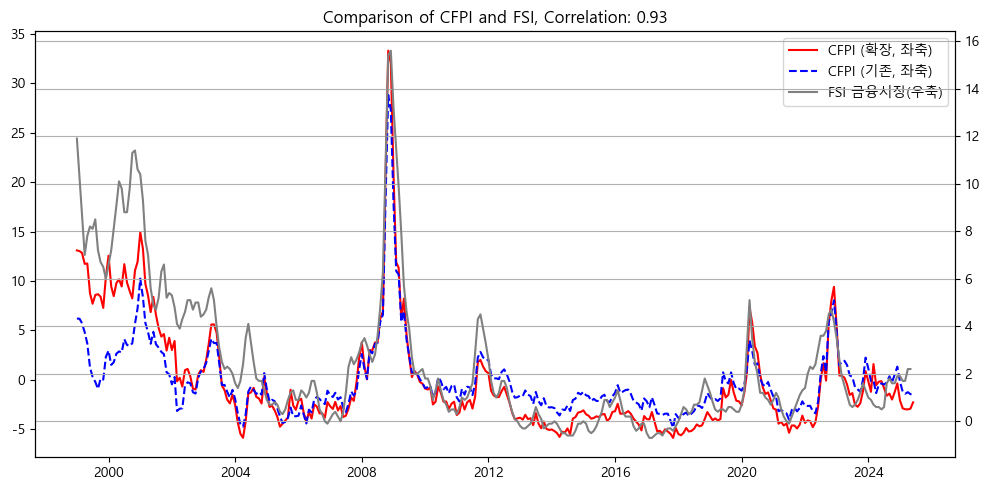

In [12]:
# CFPI와 FSI 비교
cfpi_fsi = pd.DataFrame({'cfpi': cfpi, 'cfpi_bank': cfpi_bank, 'cfpi_nbank': cfpi_nbank, 'cfpi_old': cfpi_old,
                         'fsi': table_fsi['fsi'], 'fsi_fin': table_fsi['fsi_fin'], 'fsi_bank': table_fsi['fsi_bank'],'fsi_nbank': table_fsi['fsi_nbank']})
cfpi_fsi = cfpi_fsi['1999-01':'2025-06'].copy() # 기존 '1999-01':'2025-06'

fig, ax1, ax2 = ews.plot_cfpi_fsi(cfpi_fsi, figsize=(10, 5), save_path=None, dpi=300)

In [13]:
# 부문별 cfpi와 fsi(금융시장) 상관계수
corr_cfpi_fsi = cfpi_fsi['cfpi'].corr(cfpi_fsi['fsi_fin'])
corr_cfpiold_fsi = cfpi_fsi['cfpi_old'].corr(cfpi_fsi['fsi_fin'])
corr_cfpinbank_fsi = cfpi_fsi['cfpi_nbank'].corr(cfpi_fsi['fsi_fin'])

print("\nCFPI and FSI 금융시장 상관계수")
print("─" * 40)
print(f"{'CFPI (확장)':<13}: {corr_cfpi_fsi:>6.2f}")
print(f"{'CFPI_bank':<15}: {corr_cfpiold_fsi:>6.2f}")  
print(f"{'CFPI_nbank':<15}: {corr_cfpinbank_fsi:>6.2f}")
print("─" * 40)



CFPI and FSI 금융시장 상관계수
────────────────────────────────────────
CFPI (확장)    :   0.93
CFPI_bank      :   0.80
CFPI_nbank     :   0.88
────────────────────────────────────────


In [14]:
#cfpi 및 fsi 표준화
scaled = cfpi_fsi.transform(ews.Transform.scale)

### 위기 진입 및 종료 조건 변경
- 기존은 한번이라도 임계치를 넘으면 위기로 식별
- 단기 급등·급락에 의한 오경보(False Alarm)를 줄이고, 실제 위기 국면에서만 신호가 켜지도록 안정성 확보

<Figure size 640x480 with 0 Axes>

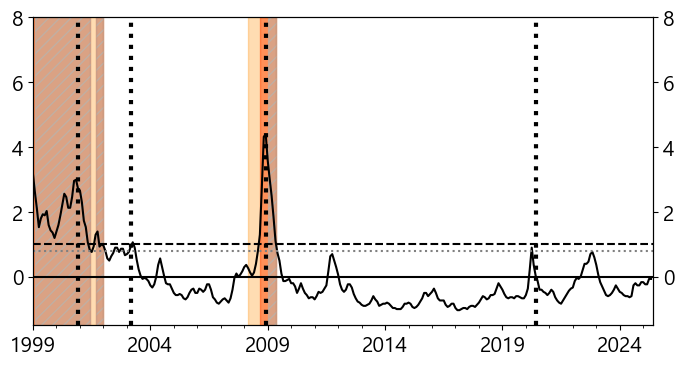

<Figure size 640x480 with 0 Axes>

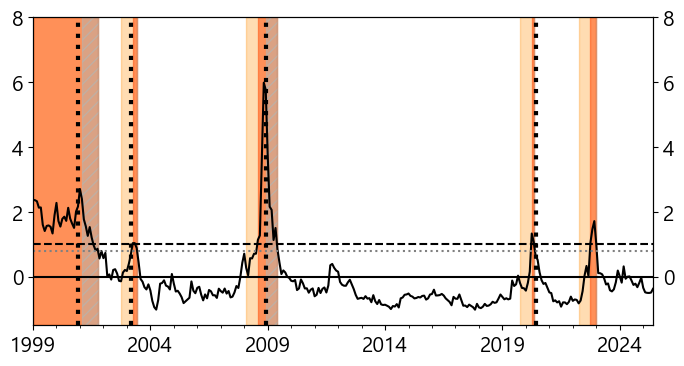

<Figure size 640x480 with 0 Axes>

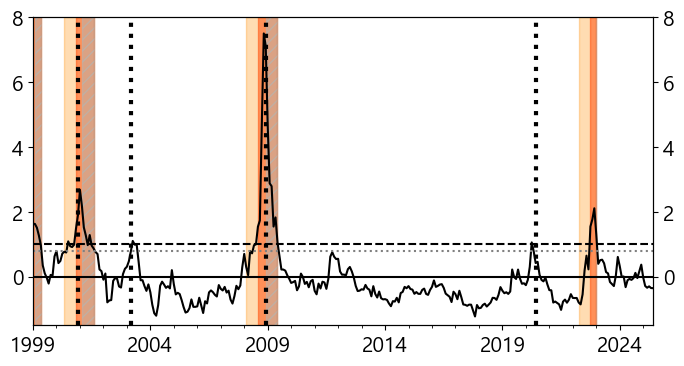

<Figure size 640x480 with 0 Axes>

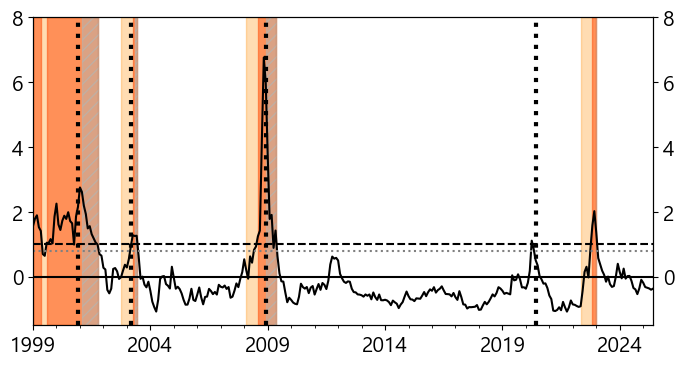

In [15]:
import matplotlib.pyplot as plt

k_in = 1 # 위기 진입 threshold
k_out = 0.8 # 위기 종료 threshold
horizon = 6 # 조기경보모형의 예측시계
en, ex = 2, 1 # 진입 및 종료 시그널
gdp_growth = table['gdp_growth'].resample('Q').mean()

plt.figure()
ews.plot_cfpi2(scaled['fsi_fin'], gdp_growth, k_in, k_out, horizon, enter=en, exit=ex, xlim = ['1999-01', '2025-06'], ylim=[-1.5, 8], figsize=(8, 4))
plt.savefig('figure/cfpi_fsi_fin.png', dpi=300, bbox_inches='tight', transparent=True)

plt.figure()
ews.plot_cfpi2(scaled['cfpi'], gdp_growth, k_in, k_out, horizon, enter=en, exit=ex, xlim = ['1999-01', '2025-06'], ylim=[-1.5, 8], figsize=(8, 4))
plt.savefig('figure/cfpi.png', dpi=300, bbox_inches='tight', transparent=True)

plt.figure()
ews.plot_cfpi2(scaled['cfpi_bank'], gdp_growth, k_in, k_out, horizon, enter=en, exit=ex, xlim = ['1999-01', '2025-06'], ylim=[-1.5, 8], figsize=(8, 4))
plt.savefig('figure/cfpi_bank.png', dpi=300, bbox_inches='tight', transparent=True)

plt.figure()
ews.plot_cfpi2(scaled['cfpi_nbank'], gdp_growth, k_in, k_out, horizon, enter=en, exit=ex, xlim = ['1999-01', '2025-06'], ylim=[-1.5, 8], figsize=(8, 4))
plt.savefig('figure/cfpi_nbank.png', dpi=300, bbox_inches='tight', transparent=True)

<Figure size 640x480 with 0 Axes>

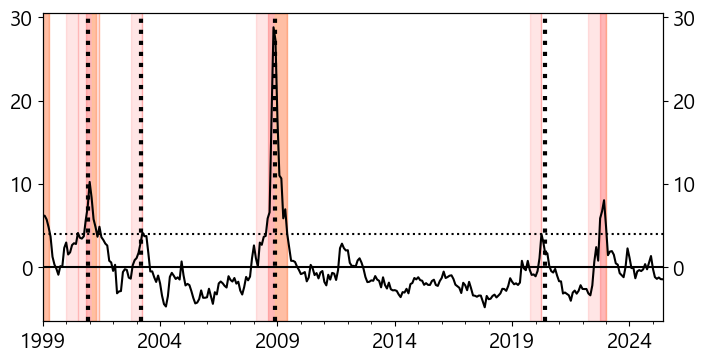

In [16]:
# 기존 cfpi 위기식별
k = 1

# CFPI 지수 생성
cfpi_old = table[CFPI_bank].transform(ews.Transform.scale).sum(axis=1)
crises_old = ews.get_crises(cfpi_old, k, horizon, group_bgn_ext=3, group_end_ext=3)
plt.figure()
ews.plot_cfpi(cfpi_old, gdp_growth, k, horizon, xlim = ['1999-01', '2025-06'], figsize=(8, 4))
plt.savefig('figure/cfpi_old.png', dpi=300, bbox_inches='tight', transparent=True)

# Ⅱ. 모형 하이퍼파라미터 튜닝 및 평가

## 1 하이퍼파라미터 튜닝

In [17]:
# scikit-learn==1.2.2, scikeras==0.12.0, tensorflow==2.9.2
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import numpy as np

tf.data.experimental.enable_debug_mode() # 디버깅 모드 활성화
tf.config.run_functions_eagerly(True) # 함수 실행 즉시 실행

In [18]:
# 인공신경망 모델 구성
def build_NN(units, features, dropout_prob=0.5):
    model = Sequential()
    model.add(Dense(units=units, activation='relu', input_shape=(features,)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# LSTM 모델 구성 (시계열 특화) - KerasClassifier 호환
def build_LSTM(units, timesteps, features=None, dropout_prob=0.5):
    # features가 None이면 기본값 사용 (런타임에 결정됨)
    if features is None:
        features = len(features['id']) if 'features' in globals() else 10
    
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(timesteps, features)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=units//2, return_sequences=False))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units//2, activation='relu'))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

class LSTMClassifier(BaseEstimator, ClassifierMixin):
    """
    scikit-learn 호환 LSTM 분류기 래퍼
    """
    def __init__(self, units=32, timesteps=12, dropout_prob=0.5,
                 batch_size=32, epochs=10, verbose=0):
        self.units = units
        self.timesteps = timesteps
        self.dropout_prob = dropout_prob
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        # 클래스 속성 초기화
        self.keras_classifier_ = None
        self.classes_ = None

    def fit(self, X, y, **fit_params):
        # 1) 데이터 시퀀스 변환
        X_seq, y_seq = self._prepare_data(X, y)
        # 2) scikeras KerasClassifier 생성
        self.keras_classifier_ = KerasClassifier(
            model=build_LSTM,
            units=self.units,
            timesteps=self.timesteps,
            features=X_seq.shape[2],
            dropout_prob=self.dropout_prob,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose
        )
        # 3) 내부 모델 학습
        self.keras_classifier_.fit(X_seq, y_seq, **fit_params)
        # 4) classes_ 속성 복사
        self.classes_ = self.keras_classifier_.classes_
        return self

    def predict(self, X):
        X_seq, _ = self._prepare_data(X, None)
        return self.keras_classifier_.predict(X_seq)

    def predict_proba(self, X):
        X_seq, _ = self._prepare_data(X, None)
        return self.keras_classifier_.predict_proba(X_seq)

    def _prepare_data(self, X, y):
        # numpy array로 변환
        X_vals = X.values if hasattr(X, 'values') else np.asarray(X)
        n_samples, n_features = X_vals.shape
        seq_len = min(self.timesteps, n_samples)
        # sliding window 또는 패딩
        X_seq = np.zeros((n_samples, seq_len, n_features))
        for i in range(n_samples):
            if i < seq_len:
                pad = np.zeros((seq_len - (i+1), n_features))
                X_seq[i] = np.vstack([pad, X_vals[:i+1]])
            else:
                X_seq[i] = X_vals[i-seq_len+1:i+1]
        if y is not None:
            y_vals = y.values if hasattr(y, 'values') else np.asarray(y)
            return X_seq, y_vals
        return X_seq, None

# 평가 대상 모델 정의 (LSTM, CatBoost, LightGBM 추가)
models = {
    'SE': ews.SignalExtraction(),
    'LR': LogisticRegression(max_iter=1000),
    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),
    'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5),
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True),
    'NN': KerasClassifier(model=build_NN, units=10, features=len(features['id']), verbose=0),
    # 'LSTM': LSTMClassifier(units=32, timesteps=12, dropout_prob=0.5, epochs=20, batch_size=30, verbose=0),
    'RF': RandomForestClassifier(criterion='entropy'),
    'XGB': XGBClassifier(eval_metric='logloss'),
    # 'CatBoost': CatBoostClassifier(verbose=False),
    'LightGBM': LGBMClassifier(verbose=-1),
    'ET': ExtraTreesClassifier(),
    'LassoET': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection',
            SelectFromModel(
                LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
                threshold='mean',
                prefit=False
            )
        ),
        ('clf', ExtraTreesClassifier())
    ]),
    'RFET': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection',
            SelectFromModel(
                RandomForestClassifier(criterion='entropy'),
                threshold='mean',
                prefit=False
            )
        ),
        ('clf', ExtraTreesClassifier())
    ]),
}

models_og = {
    'SE': ews.SignalExtraction(),
    'LR': LogisticRegression(max_iter=1000),
    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),
    'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5),
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True),
    'NN': KerasClassifier(model=build_NN, units=10, features=len(features_old['id']), verbose=0),
    # 'LSTM': LSTMClassifier(units=32, timesteps=12, dropout_prob=0.5, epochs=20, batch_size=30, verbose=0),
    'RF': RandomForestClassifier(criterion='entropy'),
    'XGB': XGBClassifier(eval_metric='logloss'),
    # 'CatBoost': CatBoostClassifier(verbose=False),
    'LightGBM': LGBMClassifier(verbose=-1),
    'ET': ExtraTreesClassifier(),
    'LassoET': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection',
            SelectFromModel(
                LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
                threshold='mean',
                prefit=False
            )
        ),
        ('clf', ExtraTreesClassifier())
    ]),
    'RFET': Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection',
            SelectFromModel(
                RandomForestClassifier(criterion='entropy'),
                threshold='mean',
                prefit=False
            )
        ),
        ('clf', ExtraTreesClassifier())
    ]),
}


# 모델별 하이퍼파라미터 탐색 범위 정의 (신규 모델 포함)
model_param_grids = {
    'SE': {'significance': [0.9]}, #{'significance': [0.7, 0.75, 0.8, 0.85, 0.9]},
    'LR': {},
    'Lasso': {'C': [1, 5, 10]},
    'Ridge': {'C': [0.1, 1, 10, 20]},
    'ElasticNet': {
        'C': [0.1, 1, 5, 10],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': [0.01, 0.1, 1],
        'kernel': ['rbf', 'linear']
    },
    'NN': {
        'units': [5, 10, 30, 50],
        'batch_size': [30],
    },
    # 'LSTM': {
    #    'timesteps': [6, 12, 18],
    #    'units': [16, 32, 64],
    #    'batch_size': [30]
    # },
    'RF': {
        'n_estimators': [1000],
        #'max_features': [0.05, 0.07, 0.1, 0.3, 0.5],
        'max_features': [0.1],
        #'max_features': [1, 2, 3, 5, 7, 10, 15, 20, 30, 40],
        #'max_depth': [5, 7, 10, 15, 20, 30]
        'max_depth': [10]
    },
    'XGB': {
        'n_estimators': [1000],
        'max_depth': [3, 5],
        'gamma': [0.03, 0.1],
        'colsample_bytree': [0.4],
        'min_child_weight': [1.5, 3],
        'learning_rate': [0.1],
        'reg_alpha': [0.75],
        'reg_lambda': [0.45],
        'subsample': [0.95],
        'objective': ['binary:logistic']
    },
    # 'CatBoost': {
    #    'iterations': [500, 1000],
    #    'depth': [4, 6, 8],
    #    'learning_rate': [0.03, 0.1, 0.2],
    #    'l2_leaf_reg': [1, 3, 5]
    # },
    'LightGBM': {
       'n_estimators': [1000],
       'max_depth': [3, 5],
       'learning_rate': [0.1],
       'num_leaves': [31, 63],
       'subsample': [0.95],
       'colsample_bytree': [0.8, 0.9]
    },
    'ET': {
        'n_estimators': [500],
        #'max_features': [1, 2, 3, 5, 7],
        #'max_features': [0.05, 0.07, 0.1, 0.3, 0.5],
        'max_features': [0.1],
        #'max_depth': [5, 7, 10, 15, 20, 30]
        'max_depth': [20]
    },
    'LassoET': {
        # Lasso α 값
        'feature_selection__estimator__C': [5],
        # threshold 옵션 (평균·중앙값 기준)
        'feature_selection__threshold': ['mean'],
        # ExtraTreesClassifier 하이퍼파라미터
        'clf__n_estimators': [500],
        'clf__max_features': [0.1],
        'clf__max_depth': [10]
    },
    'RFET': {
        # RF
        'feature_selection__estimator__n_estimators': [100], # 500
        'feature_selection__estimator__max_features': [0.5], # 0.1
        'feature_selection__estimator__max_depth': [5],
        # threshold 옵션 (평균·중앙값 기준)
        'feature_selection__threshold': ['mean'],
        # ExtraTreesClassifier 하이퍼파라미터
        'clf__n_estimators': [1000], # 500
        'clf__max_features': [0.3],
        'clf__max_depth': [15]
    },
}

In [19]:
ews.set_all_seeds()
# 하이퍼파라미터 튜닝 실행
crises = ews.get_crises2(cfpi['1999-01':'2025-06'], k_in, k_out, horizon=6, enter=2, exit=1, group_bgn_ext=3, group_end_ext=3) # scaled['cfpi']
crises_group = set(crises.loc[crises['ext_term'] == 1, 'groups'].unique()) # 위기그룹 추출, leave one episode out 방식을 위한 그룹설정
best_params, preds = ews.run_cv(models, model_param_grids, table[features['id']]['1999-01':'2025-06'], crises,
                                cv_method='sgkf', n_splits=5, cv_inner_method='sgkf', inner_splits=4, crises_groups=crises_group) # inner_splits=4

Generated 5 folds(episodes) for cross-validation.


  0%|          | 0/13 [00:00<?, ?it/s]

SE 0 - Best Score: 0.915368, Best Params: {'significance': 0.9}
SE 1 - Best Score: 0.900929, Best Params: {'significance': 0.9}
SE 2 - Best Score: 0.860650, Best Params: {'significance': 0.9}
SE 3 - Best Score: 0.922889, Best Params: {'significance': 0.9}
SE 4 - Best Score: 0.934129, Best Params: {'significance': 0.9}
LR 0 - Best Score: 0.860132, Best Params: {}
LR 1 - Best Score: 0.611728, Best Params: {}
LR 2 - Best Score: 0.607899, Best Params: {}
LR 3 - Best Score: 0.913830, Best Params: {}
LR 4 - Best Score: 0.847505, Best Params: {}
Lasso 0 - Best Score: 0.954011, Best Params: {'C': 1}
Lasso 1 - Best Score: 0.782955, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.749047, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.935470, Best Params: {'C': 1}
Lasso 4 - Best Score: 0.924041, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.906259, Best Params: {'C': 20}
Ridge 1 - Best Score: 0.711539, Best Params: {'C': 0.1}
Ridge 2 - Best Score: 0.749799, Best Params: {'C': 0.1}
Ridge 3 - Best Sco

  0%|          | 0/13 [00:00<?, ?it/s]

            tp   tn   fp  fn       acc       tpr       fpr       nsr  \
SE          38  234    6  40  0.855346  0.487179  0.025000  0.051316   
LR          31  225   15  47  0.805031  0.397436  0.062500  0.157258   
Lasso       36  220   20  42  0.805031  0.461538  0.083333  0.180556   
Ridge       30  232    8  48  0.823899  0.384615  0.033333  0.086667   
ElasticNet  31  231    9  47  0.823899  0.397436  0.037500  0.094355   
SVM         15  238    2  63  0.795597  0.192308  0.008333  0.043333   
NN          74    5  235   4  0.248428  0.948718  0.979167  1.032095   
RF          57  221   19  21  0.874214  0.730769  0.079167  0.108333   
XGB         48  231    9  30  0.877358  0.615385  0.037500  0.060937   
LightGBM    29  238    2  49  0.839623  0.371795  0.008333  0.022414   
ET          52  228   12  26  0.880503  0.666667  0.050000  0.075000   
LassoET     65  133  107  13  0.622642  0.833333  0.445833  0.535000   
RFET        58  228   12  20  0.899371  0.743590  0.050000  0.06

In [108]:
preds.to_pickle('output/preds.pkl')  # 예측 결과 저장
pd.DataFrame(best_params).to_pickle('output/best_params.pkl')  # 하이퍼파라미터 저장

#### best_params
```python
- 'SE': {'significance': 0.8}
- 'LR': {}, 'Lasso': {'C': 1}, 'Ridge': {'C': 0.1}, 'ElasticNet': {'C': 0.1, 'l1_ratio': 0.5} 
- 'SVM': {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
- 'NN': {'batch_size': 30, 'units': 50}, 
- 'RF': {'max_depth': 10, 'max_features': 0.1, 'n_estimators': 1000, 'n_jobs': -1}
- 'XGB': {'colsample_bytree': 0.4, 'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'reg_alpha': 0.75, 'reg_lambda': 0.45, 'subsample': 0.95}, 
- 'ET': {'max_depth': 20, 'max_features': 0.1, 'n_estimators': 100, 'n_jobs': -1}
- 'LassoET': {'clf__max_depth': 10, 'clf__max_features': 0.1, 'clf__n_estimators': 500, 'clf__n_jobs': -1, 'feature_selection__estimator__C': 5, 'feature_selection__threshold': 'mean'}, 
- 'RFET': {'clf__max_depth': 15, 'clf__max_features': 0.3, 'clf__n_estimators': 500, 'clf__n_jobs': -1, 'feature_selection__estimator__max_depth': 5, 'feature_selection__estimator__max_features': 0.1, 'feature_selection__estimator__n_estimators': 500, 'feature_selection__threshold': 'mean'}}
```

### 예측변수 확대 효과 비교(ET43 vs ET15)

In [20]:
ews.set_all_seeds() # 시드 고정
# 하이퍼파라미터 튜닝(target: new crises, feature: 기존 feature만 사용)
best_params_old, preds_old = ews.run_cv({'ET15': ExtraTreesClassifier(random_state=123)}, 
                                        {'ET15': {'n_estimators': [1000], 'max_depth': [5, 7, 10, 20, 30], 'max_features': [3, 5, 7, 10, 15]}}, 
                                        table[features_old['id']]['1999-01':'2025-06'], crises,
                                         cv_method='sgkf', n_splits=5, cv_inner_method='sgkf', inner_splits=4, crises_groups=crises_group)

Generated 5 folds(episodes) for cross-validation.


  0%|          | 0/1 [00:00<?, ?it/s]

ET15 0 - Best Score: 0.951704, Best Params: {'max_depth': 10, 'max_features': 5, 'n_estimators': 1000}
ET15 1 - Best Score: 0.930061, Best Params: {'max_depth': 20, 'max_features': 3, 'n_estimators': 1000}
ET15 2 - Best Score: 0.930345, Best Params: {'max_depth': 20, 'max_features': 5, 'n_estimators': 1000}
ET15 3 - Best Score: 0.952620, Best Params: {'max_depth': 20, 'max_features': 5, 'n_estimators': 1000}
ET15 4 - Best Score: 0.974888, Best Params: {'max_depth': 7, 'max_features': 10, 'n_estimators': 1000}
best_params =  {'ET15': {'max_depth': 7, 'max_features': 10, 'n_estimators': 1000}}


  0%|          | 0/1 [00:00<?, ?it/s]

      tp   tn  fp  fn       acc       tpr       fpr       nsr        f1    auc
ET15  53  221  19  25  0.861635  0.679487  0.079167  0.116509  0.706667  0.925


In [21]:
ews.set_all_seeds()
_, preds_et43 = ews.run_cv({'ET43': ExtraTreesClassifier(random_state=123)}, 
                           {'ET43': {'n_estimators': [1000], 'max_depth': [5, 7, 10, 20, 30], 'max_features': [3, 5, 7, 10, 15, 20, 30, 40]}}, 
                           table[features['id']]['1999-01':'2025-06'], crises,
                           cv_method='sgkf', n_splits=5, cv_inner_method='sgkf', inner_splits=4, crises_groups=crises_group)

Generated 5 folds(episodes) for cross-validation.


  0%|          | 0/1 [00:00<?, ?it/s]

ET43 0 - Best Score: 0.967492, Best Params: {'max_depth': 20, 'max_features': 10, 'n_estimators': 1000}
ET43 1 - Best Score: 0.927824, Best Params: {'max_depth': 20, 'max_features': 3, 'n_estimators': 1000}
ET43 2 - Best Score: 0.930737, Best Params: {'max_depth': 20, 'max_features': 3, 'n_estimators': 1000}
ET43 3 - Best Score: 0.964588, Best Params: {'max_depth': 20, 'max_features': 7, 'n_estimators': 1000}
ET43 4 - Best Score: 0.967450, Best Params: {'max_depth': 20, 'max_features': 7, 'n_estimators': 1000}
best_params =  {'ET43': {'max_depth': 20, 'max_features': 10, 'n_estimators': 1000}}


  0%|          | 0/1 [00:00<?, ?it/s]

      tp   tn  fp  fn       acc       tpr       fpr       nsr        f1  \
ET43  53  226  14  25  0.877358  0.679487  0.058333  0.085849  0.731034   

           auc  
ET43  0.941106  


In [109]:
preds_old.to_pickle('output/preds_old.pkl')  # 예측 결과 저장
pd.DataFrame(best_params_old).to_pickle('output/best_params_old.pkl')  # 하이퍼파라미터 저장

### 기존 조기경보모형 교차검증

In [22]:
ews.set_all_seeds() # 시드 고정
# 하이퍼파라미터 튜닝(target: 과거 기준 crises, feature: 기존 feature만 사용)
crises_og = ews.get_crises(cfpi_old['1997-07':'2025-06'], k=1, horizon=6, group_bgn_ext=3, group_end_ext=3)
best_params_og, preds_og = ews.run_cv(models_og, model_param_grids, table[features_old['id']]['1997-07':'2025-06'], crises_og,
                                      cv_method='sgkf', n_splits=5, cv_inner_method='sgkf', inner_splits=4)

Generated 5 folds(episodes) for cross-validation.


  0%|          | 0/13 [00:00<?, ?it/s]

SE 0 - Best Score: 0.823970, Best Params: {'significance': 0.9}
SE 1 - Best Score: 0.843051, Best Params: {'significance': 0.9}
SE 2 - Best Score: 0.865290, Best Params: {'significance': 0.9}
SE 3 - Best Score: 0.878276, Best Params: {'significance': 0.9}
SE 4 - Best Score: 0.869900, Best Params: {'significance': 0.9}
LR 0 - Best Score: 0.683417, Best Params: {}
LR 1 - Best Score: 0.600079, Best Params: {}
LR 2 - Best Score: 0.584220, Best Params: {}
LR 3 - Best Score: 0.760185, Best Params: {}
LR 4 - Best Score: 0.770214, Best Params: {}
Lasso 0 - Best Score: 0.681149, Best Params: {'C': 1}
Lasso 1 - Best Score: 0.654913, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.627561, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.825315, Best Params: {'C': 1}
Lasso 4 - Best Score: 0.832759, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.746794, Best Params: {'C': 0.1}
Ridge 1 - Best Score: 0.698463, Best Params: {'C': 0.1}
Ridge 2 - Best Score: 0.740933, Best Params: {'C': 0.1}
Ridge 3 - Best Sc

  0%|          | 0/13 [00:00<?, ?it/s]

            tp   tn   fp  fn       acc       tpr       fpr       nsr  \
SE          27  255    6  48  0.839286  0.360000  0.022989  0.063857   
LR          45  213   48  30  0.767857  0.600000  0.183908  0.306513   
Lasso       44  214   47  31  0.767857  0.586667  0.180077  0.306949   
Ridge       56  181   80  19  0.705357  0.746667  0.306513  0.410509   
ElasticNet  71  163   98   4  0.696429  0.946667  0.375479  0.396633   
SVM          0  261    0  75  0.776786  0.000000  0.000000       NaN   
NN          75    1  260   0  0.226190  1.000000  0.996169  0.996169   
RF          62  234   27  13  0.880952  0.826667  0.103448  0.125139   
XGB         40  252    9  35  0.869048  0.533333  0.034483  0.064655   
LightGBM    13  261    0  62  0.815476  0.173333  0.000000       NaN   
ET          60  241   20  15  0.895833  0.800000  0.076628  0.095785   
LassoET     69  166   95   6  0.699405  0.920000  0.363985  0.395636   
RFET        56  229   32  19  0.848214  0.746667  0.122605  0.16

In [247]:
crises_og = crises_og.loc['1999-01':'2025-06']

In [110]:
preds_og.to_pickle('output/preds_og.pkl')  # 예측 결과 저장
pd.DataFrame(best_params_og).to_pickle('output/best_params_og.pkl')  # 하이퍼파라미터 저장

### 은행부문 교차검증

In [23]:
ews.set_all_seeds() # 시드 고정
# 하이퍼파라미터 튜닝(은행 부문)
crises_bank = ews.get_crises2(cfpi_bank['1999-01':'2025-06'], k_in, k_out, horizon=6, enter=2, exit=1, group_bgn_ext=3, group_end_ext=3) # scaled['cfpi']
crises_group_bank = set(crises_bank.loc[crises_bank['ext_term'] == 1, 'groups'].unique())
best_params_bank, preds_bank = ews.run_cv(models, model_param_grids, table[features['id']]['1999-01':'2025-06'], crises_bank,
                                          cv_method='sgkf', n_splits=5, cv_inner_method='sgkf', inner_splits=3, crises_groups=crises_group_bank)

Generated 5 folds(episodes) for cross-validation.


  0%|          | 0/13 [00:00<?, ?it/s]

SE 0 - Best Score: 0.921397, Best Params: {'significance': 0.9}
SE 1 - Best Score: 0.930370, Best Params: {'significance': 0.9}
SE 2 - Best Score: 0.954054, Best Params: {'significance': 0.9}
SE 3 - Best Score: 0.865098, Best Params: {'significance': 0.9}
SE 4 - Best Score: 0.965971, Best Params: {'significance': 0.9}
LR 0 - Best Score: 0.936831, Best Params: {}
LR 1 - Best Score: 0.935267, Best Params: {}
LR 2 - Best Score: 0.840678, Best Params: {}
LR 3 - Best Score: 0.873777, Best Params: {}
LR 4 - Best Score: 0.903900, Best Params: {}
Lasso 0 - Best Score: 0.936174, Best Params: {'C': 1}
Lasso 1 - Best Score: 0.993335, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.978618, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.952478, Best Params: {'C': 5}
Lasso 4 - Best Score: 0.971847, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.977024, Best Params: {'C': 20}
Ridge 1 - Best Score: 0.973897, Best Params: {'C': 20}
Ridge 2 - Best Score: 0.925332, Best Params: {'C': 0.1}
Ridge 3 - Best Scor

  0%|          | 0/13 [00:00<?, ?it/s]

            tp   tn   fp  fn       acc       tpr       fpr       nsr  \
SE          20  267    3  28  0.902516  0.416667  0.011111  0.026667   
LR          21  257   13  27  0.874214  0.437500  0.048148  0.110053   
Lasso       26  258   12  22  0.893082  0.541667  0.044444  0.082051   
Ridge       17  256   14  31  0.858491  0.354167  0.051852  0.146405   
ElasticNet  19  257   13  29  0.867925  0.395833  0.048148  0.121637   
SVM          0  270    0  48  0.849057  0.000000  0.000000       NaN   
NN          48    0  270   0  0.150943  1.000000  1.000000  1.000000   
RF          24  264    6  24  0.905660  0.500000  0.022222  0.044444   
XGB         19  265    5  29  0.893082  0.395833  0.018519  0.046784   
LightGBM     8  268    2  40  0.867925  0.166667  0.007407  0.044444   
ET          15  268    2  33  0.889937  0.312500  0.007407  0.023704   
LassoET     46  213   57   2  0.814465  0.958333  0.211111  0.220290   
RFET        16  260   10  32  0.867925  0.333333  0.037037  0.11

In [111]:
preds_bank.to_pickle('output/preds_bank.pkl')  # 예측 결과 저장
pd.DataFrame(best_params_bank).to_pickle('output/best_params_bank.pkl')  # 하이퍼파라미터 저장

### 비은행부문 교차검증

In [24]:
ews.set_all_seeds() # 시드 고정
# 하이퍼파라미터 튜닝(비은행 부문)
crises_nbank = ews.get_crises2(cfpi_nbank['1999-01':'2025-06'], k_in, k_out, horizon=6, enter=2, exit=1, group_bgn_ext=3, group_end_ext=3) # scaled['cfpi']
crises_group_nbank = set(crises_nbank.loc[crises_nbank['ext_term'] == 1, 'groups'].unique())
best_params_nbank, preds_nbank = ews.run_cv(models, model_param_grids, table[features['id']]['1999-01':'2025-06'], crises_nbank,
                                            cv_method='sgkf', n_splits=5, cv_inner_method='sgkf', inner_splits=3, crises_groups=crises_group_nbank)

Generated 5 folds(episodes) for cross-validation.


  0%|          | 0/13 [00:00<?, ?it/s]

SE 0 - Best Score: 0.878172, Best Params: {'significance': 0.9}
SE 1 - Best Score: 0.955026, Best Params: {'significance': 0.9}
SE 2 - Best Score: 0.922322, Best Params: {'significance': 0.9}
SE 3 - Best Score: 0.955499, Best Params: {'significance': 0.9}
SE 4 - Best Score: 0.921224, Best Params: {'significance': 0.9}
LR 0 - Best Score: 0.665936, Best Params: {}
LR 1 - Best Score: 0.887193, Best Params: {}
LR 2 - Best Score: 0.716163, Best Params: {}
LR 3 - Best Score: 0.904527, Best Params: {}
LR 4 - Best Score: 0.782878, Best Params: {}
Lasso 0 - Best Score: 0.750105, Best Params: {'C': 10}
Lasso 1 - Best Score: 0.931998, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.773305, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.934801, Best Params: {'C': 10}
Lasso 4 - Best Score: 0.877787, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.829733, Best Params: {'C': 20}
Ridge 1 - Best Score: 0.917696, Best Params: {'C': 0.1}
Ridge 2 - Best Score: 0.839722, Best Params: {'C': 20}
Ridge 3 - Best Sc

  0%|          | 0/13 [00:00<?, ?it/s]

            tp   tn   fp  fn       acc       tpr    fpr       nsr        f1  \
SE          33  240   10  35  0.858491  0.485294  0.040  0.082424  0.594595   
LR          25  236   14  43  0.820755  0.367647  0.056  0.152320  0.467290   
Lasso       26  241    9  42  0.839623  0.382353  0.036  0.094154  0.504854   
Ridge       21  241    9  47  0.823899  0.308824  0.036  0.116571  0.428571   
ElasticNet  22  243    7  46  0.833333  0.323529  0.028  0.086545  0.453608   
SVM          0  250    0  68  0.786164  0.000000  0.000       NaN  0.000000   
NN          68    0  250   0  0.213836  1.000000  1.000  1.000000  0.352332   
RF          44  234   16  24  0.874214  0.647059  0.064  0.098909  0.687500   
XGB         33  239   11  35  0.855346  0.485294  0.044  0.090667  0.589286   
LightGBM    17  247    3  51  0.830189  0.250000  0.012  0.048000  0.386364   
ET          43  237   13  25  0.880503  0.632353  0.052  0.082233  0.693548   
LassoET     49  191   59  19  0.754717  0.720588  0.

In [112]:
preds_nbank.to_pickle('output/preds_nbank.pkl')  # 예측 결과 저장
pd.DataFrame(best_params_nbank).to_pickle('output/best_params_nbank.pkl')  # 하이퍼파라미터 저장

In [35]:
preds = pd.read_pickle('output/preds.pkl')
preds_old = pd.read_pickle('output/preds_old.pkl')
preds_og = pd.read_pickle('output/preds_og.pkl')
preds_bank = pd.read_pickle('output/preds_bank.pkl')
preds_nbank = pd.read_pickle('output/preds_nbank.pkl')

In [36]:
# 경보지수 평균, 중위값, 70분위, 90분위 값
mean_value = preds['ET'].mean()
median_value = preds['ET'].median()
mean_value_bank = preds_bank['ET'].mean()
median_value_bank = preds_bank['ET'].median()
mean_value_nbank = preds_nbank['ET'].mean()
median_value_nbank = preds_nbank['ET'].median()
mean_value_old = preds_old['ET15'].mean()
median_value_old = preds_old['ET15'].median()
mean_value_og = preds_og['ET'].mean()
median_value_og = preds_og['ET'].median()
perc70 = preds['ET'].quantile(0.7)
perc80 = preds['ET'].quantile(0.8)
perc85 = preds['ET'].quantile(0.85)
perc90 = preds['ET'].quantile(0.9)
perc70_bank = preds_bank['ET'].quantile(0.7)
perc85_bank = preds_bank['ET'].quantile(0.85)
perc90_bank = preds_bank['ET'].quantile(0.9)
perc70_nbank = preds_nbank['ET'].quantile(0.7)
perc80_nbank = preds_nbank['ET'].quantile(0.8)
perc85_nbank = preds_nbank['ET'].quantile(0.85)
perc90_nbank = preds_nbank['ET'].quantile(0.9)
perc70_old = preds_old['ET15'].quantile(0.7)
perc80_old = preds_old['ET15'].quantile(0.8)
perc90_old = preds_old['ET15'].quantile(0.9)
perc70_og = preds_og['ET'].quantile(0.7)
perc85_og = preds_og['ET'].quantile(0.85)
perc90_og = preds_og['ET'].quantile(0.9)

# 데이터 정리
summary_data = {
    'CFPI': ['CFPI_all', 'CFPI_bank', 'CFPI_nbank', 'CFPI_old', 'CFPI_og'],
    'Mean': [mean_value, mean_value_bank, mean_value_nbank, mean_value_old, mean_value_og],
    'Median': [median_value, median_value_bank, median_value_nbank, median_value_old, median_value_og],
    '70th_Percentile': [perc70, perc70_bank, perc70_nbank, perc70_old, perc70_og],
    '90th_Percentile': [perc90, perc90_bank, perc90_nbank, perc90_old, perc90_og]
}
summary_df = pd.DataFrame(summary_data)

# 기본 테이블 출력
print("="*75)
print("📊 ET 모델 예측값 통계 비교")
print("="*75)
print(summary_df.round(6))
print("="*75)

# ROC 곡선
# ews.plot_roc_curve(preds)
# ews.plot_roc_curve(preds_bank)
# ews.plot_roc_curve(preds_nbank)

📊 ET 모델 예측값 통계 비교
         CFPI      Mean    Median  70th_Percentile  90th_Percentile
0    CFPI_all  0.091691  0.030000         0.070000         0.290000
1   CFPI_bank  0.030679  0.004000         0.020000         0.110000
2  CFPI_nbank  0.067430  0.020000         0.060000         0.210000
3    CFPI_old  0.105730  0.024183         0.082573         0.372550
4     CFPI_og  0.090647  0.037036         0.113719         0.244958


## 2 과거 위기기간별 모형성능 검증

In [37]:
# 최적화된 하이퍼파라미터 불러오기
param_files = {
    'extended': 'output/best_params.pkl',
    'bank': 'output/best_params_bank.pkl',
    'nbank': 'output/best_params_nbank.pkl',
    'old': 'output/best_params_old.pkl',
    'og': 'output/best_params_og.pkl'
}

best_params_et = ews.load_params(param_files['extended'], 'ET')
best_params_bank_et = ews.load_params(param_files['bank'], 'ET')
best_params_nbank_et = ews.load_params(param_files['nbank'], 'ET')
best_params_old_et = ews.load_params(param_files['old'], 'ET15')
best_params_og_et = ews.load_params(param_files['og'], 'ET')

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

model_params =  {
    'ET': best_params_et,
    'ET_bank': best_params_bank_et,
    'ET_nbank': best_params_nbank_et,
    'ET_old': best_params_old_et,
    'ET_og': best_params_og_et
}
et_model = ExtraTreesClassifier(**model_params['ET'])
et_bank_model = ExtraTreesClassifier(**model_params['ET_bank'])
et_nbank_model = ExtraTreesClassifier(**model_params['ET_nbank'])
et_old_model = ExtraTreesClassifier(**model_params['ET_old'])
et_og_model = ExtraTreesClassifier(**model_params['ET_og'])

et = ews.EarlyWarningModel(et_model)
et_bank = ews.EarlyWarningModel(et_bank_model)
et_nbank = ews.EarlyWarningModel(et_nbank_model)
et_old = ews.EarlyWarningModel(et_old_model)
et_og = ews.EarlyWarningModel(et_og_model)

# 반복 실행을 위한 함수 - 전역변수 사용
def train_and_predict(train_from, train_to, predict_from, predict_to, fig_name='pred_decomp', print_text=True, model_type='comparison'):
    """
    조건에 따라 다른 모델 조합으로 훈련 및 예측 수행
    
    Parameters:
    -----------
    model_type : str
        'comparison' : ET, ET15, ET_baseline 비교
        'sector' : ET_bank, ET_nbank 비교
        'all' : 모든 모델 비교
    """
    # 예측구간 데이터
    predict_idx = (predict_from <= table.index) & (table.index <= predict_to)
    
    # 모든 모델의 결과를 저장할 딕셔너리
    all_results = {}
    all_impacts = {}
    
    # ET(확장 43개 변수)
    if model_type in ['comparison', 'sector', 'all']:
        train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
        train_idx &= ~predict_idx
        X_train = table[features['id']][train_idx]
        y_train = crises.ext_term[train_idx]
        X = table[features['id']][predict_idx]
        et.train(X_train, y_train)
        et_results, et_impacts = et.predict(X, True)
        all_results['ET'] = et_results
        all_impacts['ET'] = et_impacts
    
    # ET15(기존 15개 변수) 
    if model_type in ['comparison', 'all']:
        train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
        train_idx &= ~predict_idx
        X_train = table[features_old['id']][train_idx]
        y_train = crises.ext_term[train_idx]
        X = table[features_old['id']][predict_idx]
        et_old.train(X_train, y_train)
        et_old_results, et_old_impacts = et_old.predict(X, True)
        all_results['ET15'] = et_old_results
        all_impacts['ET15'] = et_old_impacts
    
    # ET_baseline(구 조기경보모형)
    if model_type in ['comparison', 'all']:
        train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises_og.post_term == 0)
        train_idx &= ~predict_idx
        X_train = table[features_old['id']][train_idx]
        y_train = crises_og.ext_term[train_idx]
        X = table[features_old['id']][predict_idx]
        et_og.train(X_train, y_train)
        et_og_results, et_og_impacts = et_og.predict(X, True)
        all_results['ET_baseline'] = et_og_results
        all_impacts['ET_baseline'] = et_og_impacts
    
    # ET_bank(은행부문)
    if model_type in ['sector', 'all']:
        train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises_bank.post_term == 0)
        train_idx &= ~predict_idx
        X_train = table[features['id']][train_idx]
        y_train = crises_bank.ext_term[train_idx]
        X = table[features['id']][predict_idx]
        et_bank.train(X_train, y_train)
        et_bank_results, et_bank_impacts = et_bank.predict(X, True)
        all_results['ET_bank'] = et_bank_results
        all_impacts['ET_bank'] = et_bank_impacts
    
    # ET_nbank (비은행부문) 모델
    if model_type in ['sector', 'all']:
        train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises_nbank.post_term == 0)
        train_idx &= ~predict_idx
        X_train = table[features['id']][train_idx]
        y_train = crises_nbank.ext_term[train_idx]
        X = table[features['id']][predict_idx]
        et_nbank.train(X_train, y_train)
        et_nbank_results, et_nbank_impacts = et_nbank.predict(X, True)
        all_results['ET_nbank'] = et_nbank_results
        all_impacts['ET_nbank'] = et_nbank_impacts
    
    # 임계치 설정(모델 타입에 따라)
    if model_type == 'comparison':
        # 모형 발전도 비교용 임계치
        threshold_values = {
            'ET': (perc70, perc85),
            'ET15': (perc70_old, perc80_old), 
            'ET_baseline': (perc70_og, perc85_og)
        }
        crisis_data = crises
        feature_list = features['id']
        feature_groups = features['group']
        
    elif model_type == 'sector':
        # 부문별 비교용 임계치
        threshold_values = {
            'ET': (perc70, perc85),
            'ET_bank': (perc70_bank, perc85_bank),
            'ET_nbank': (perc70_nbank, perc80_nbank)
        }
        crisis_data = crises  # 또는 crises_bank, crises_nbank 중 선택
        feature_list = features['id']
        feature_groups = features['group']
        
    else:  # 'all'
        # 모든 모델용 임계치 (기본값 사용)
        threshold_values = {
            'ET': (perc70, perc85),
            'ET15': (perc70_old, perc80_old),
            'ET_baseline': (perc70_og, perc85_og),
            'ET_bank': (perc70_bank, perc85_bank),
            'ET_nbank': (perc70_nbank, perc80_nbank)
        }
        crisis_data = crises
        feature_list = features['id']
        feature_groups = features['group']
    
    # 선택된 모델들의 결과만 추출
    selected_results = {k: v for k, v in all_results.items() if k in all_results}
    selected_impacts = all_impacts.get(list(selected_results.keys())[0], et_impacts if 'ET' in all_results else list(all_impacts.values())[0])
    
    # 임계치 설정(첫 번째 모델 기준)
    first_model = list(selected_results.keys())[0]
    if first_model in threshold_values:
        perc70_val, perc85_val = threshold_values[first_model]
    else:
        perc70_val, perc85_val = perc70, perc85
    
    # 예측결과 및 요인분해 차트
    ews.plot_pred_decomp(selected_results, selected_impacts, feature_list, feature_groups, 
                         crisis_data, perc70_val, perc85_val, legend_row=1, legend_col=8,
                         fig_name=fig_name, print_text=print_text)
    
    #return selected_results, selected_impacts

### 신용카드 대란 (2002년~2003년)

In [44]:
table = table['1999-01':'2025-06']
crises_og = crises_og['1999-01':'2025-06']

In [126]:
ipl.reload(ews)

<module 'ews' from 'c:\\Users\\BOK\\Desktop\\pyprojects\\ews\\ews.py'>

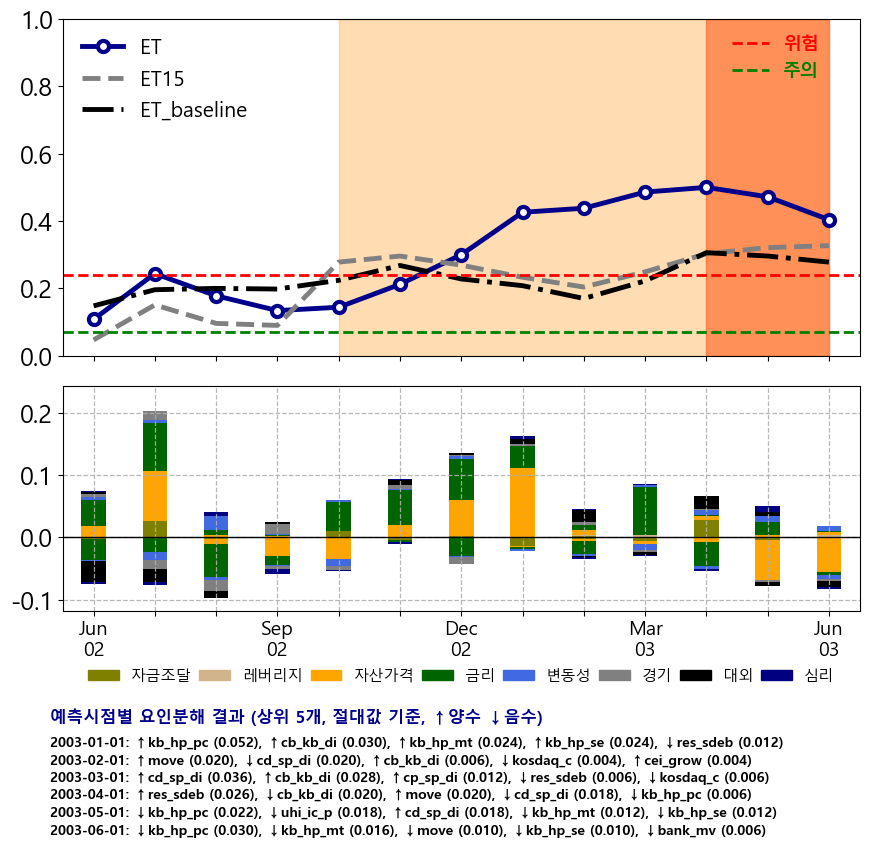

In [141]:
train_from = '1999-01'
train_to = '2002-4'
predict_from = '2002-5'
predict_to = '2003-6'

train_and_predict(train_from, train_to, predict_from, predict_to, 
                  fig_name='figure/ews_simulation1', print_text=True, model_type='comparison')

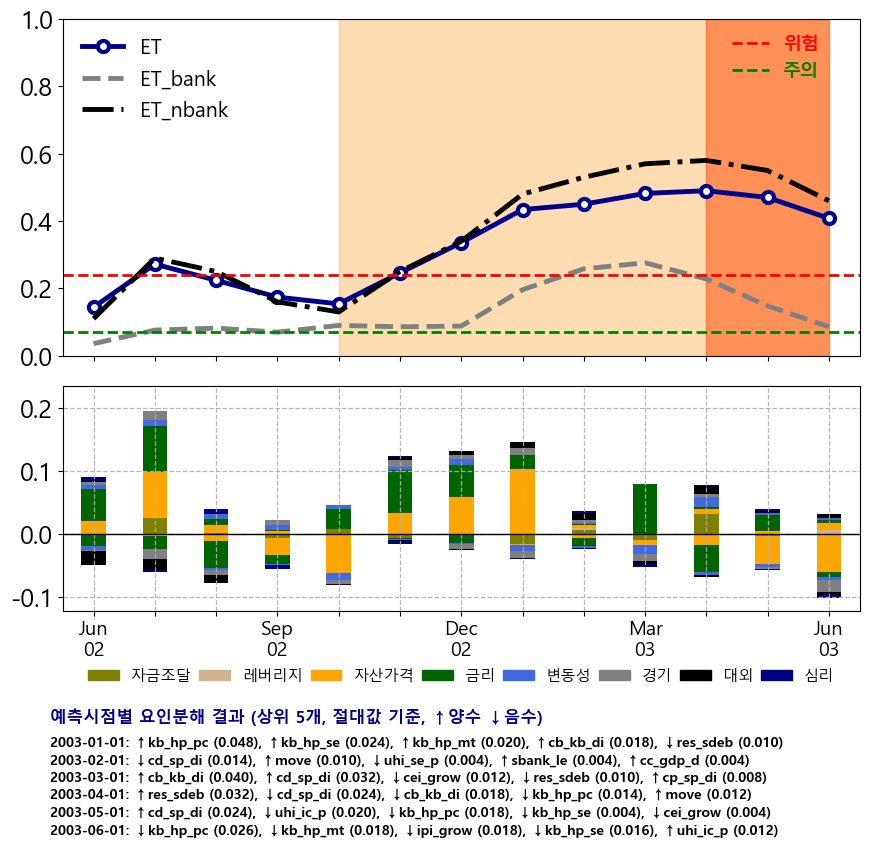

In [142]:
train_and_predict(train_from, train_to, predict_from, predict_to, 
                  fig_name='figure/ews_simulation1_sector', print_text=True, model_type='sector')

### 글로벌 금융위기 (2007.01~2008.12)

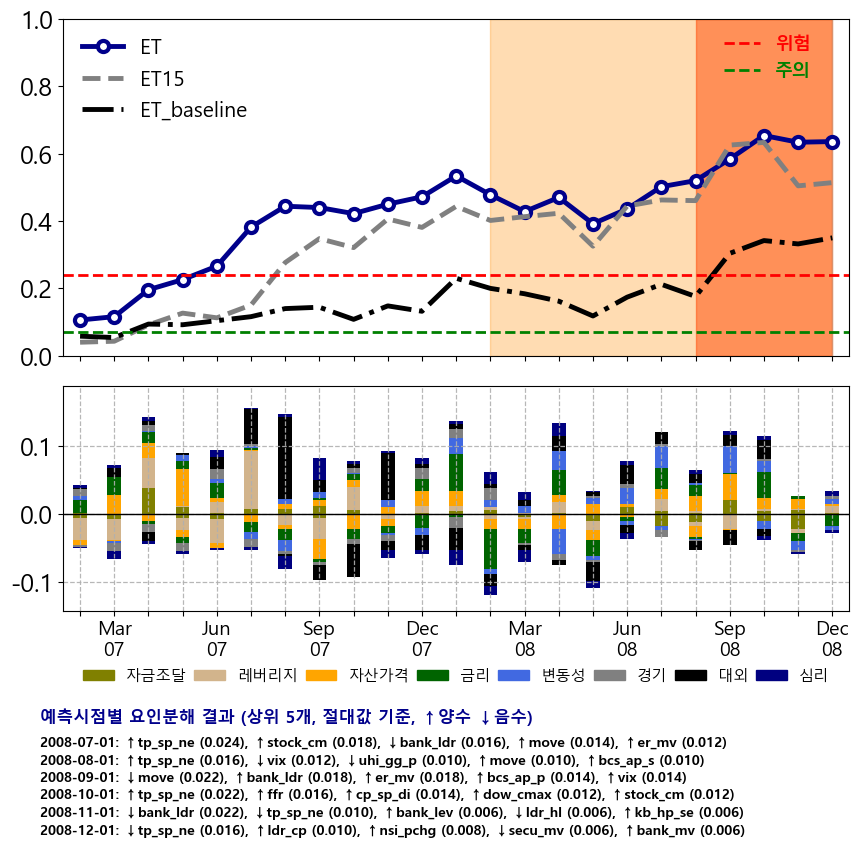

In [143]:
train_from = '1999-1'
train_to = '2006-12' #2006-6
predict_from = '2007-1' #2007-7
predict_to = '2008-12'

train_and_predict(train_from, train_to, predict_from, predict_to,
                  fig_name='figure/ews_simulation2', print_text=True, model_type='comparison')

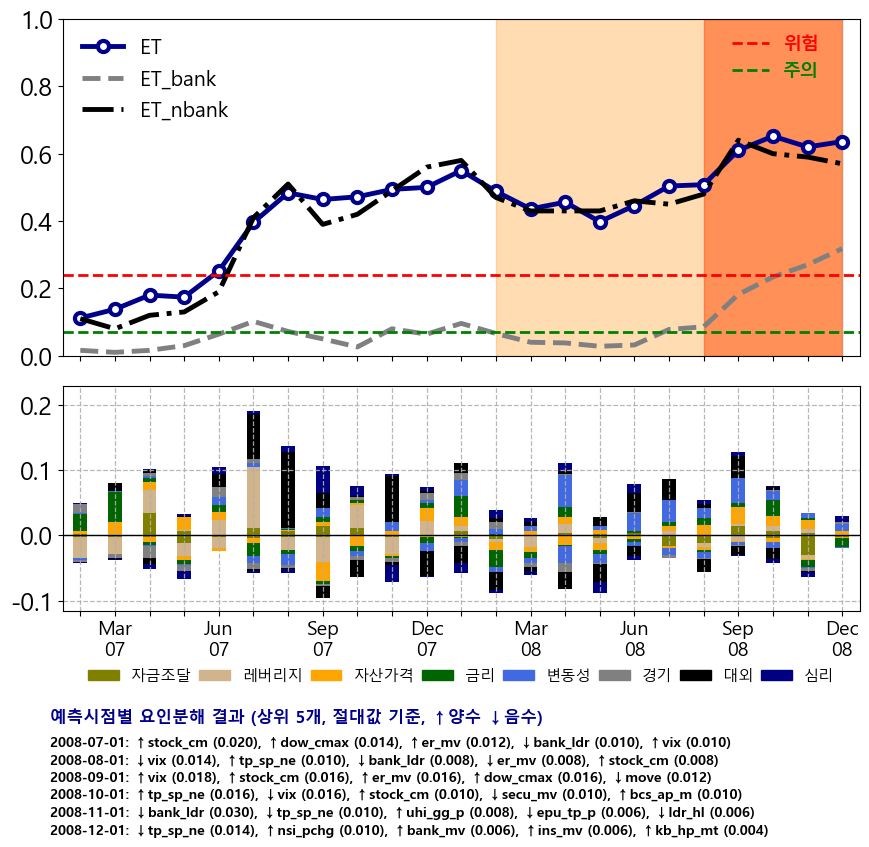

In [144]:
train_and_predict(train_from, train_to, predict_from, predict_to,
                  fig_name='figure/ews_simulation2_sector', print_text=True, model_type='sector')

### 코로나 19 (2018.10 ~ 2020.5)

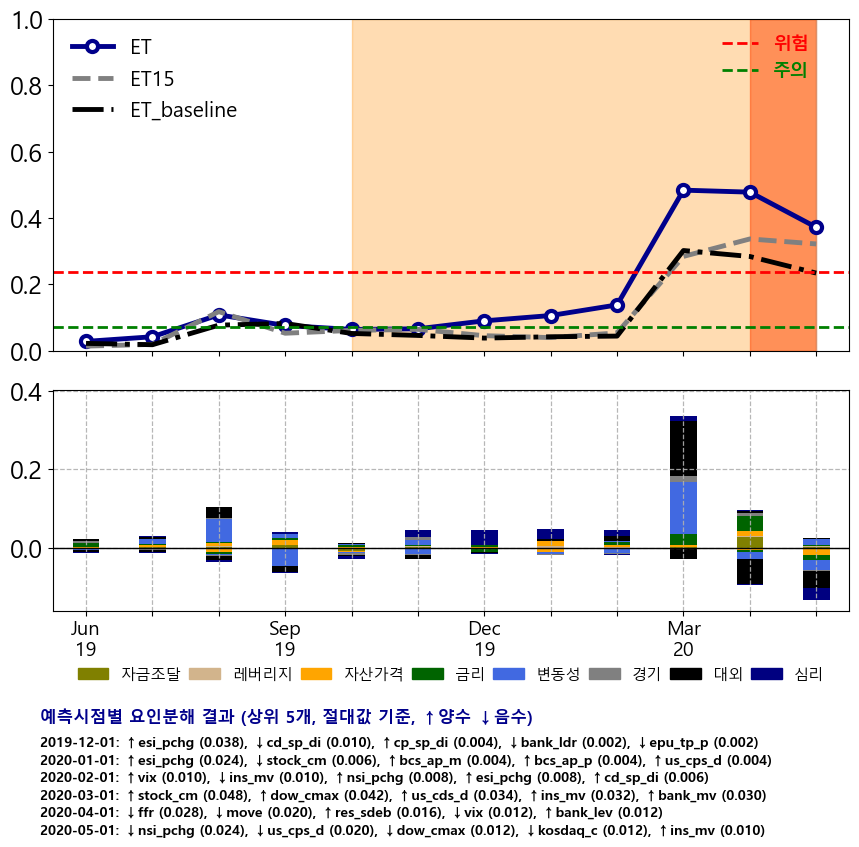

In [145]:
train_from = '1999-01'
train_to = '2019-04'
predict_from = '2019-05'
predict_to = '2020-05'

train_and_predict(train_from, train_to, predict_from, predict_to,
                  fig_name='figure/ews_simulation3', print_text=True, model_type='comparison')

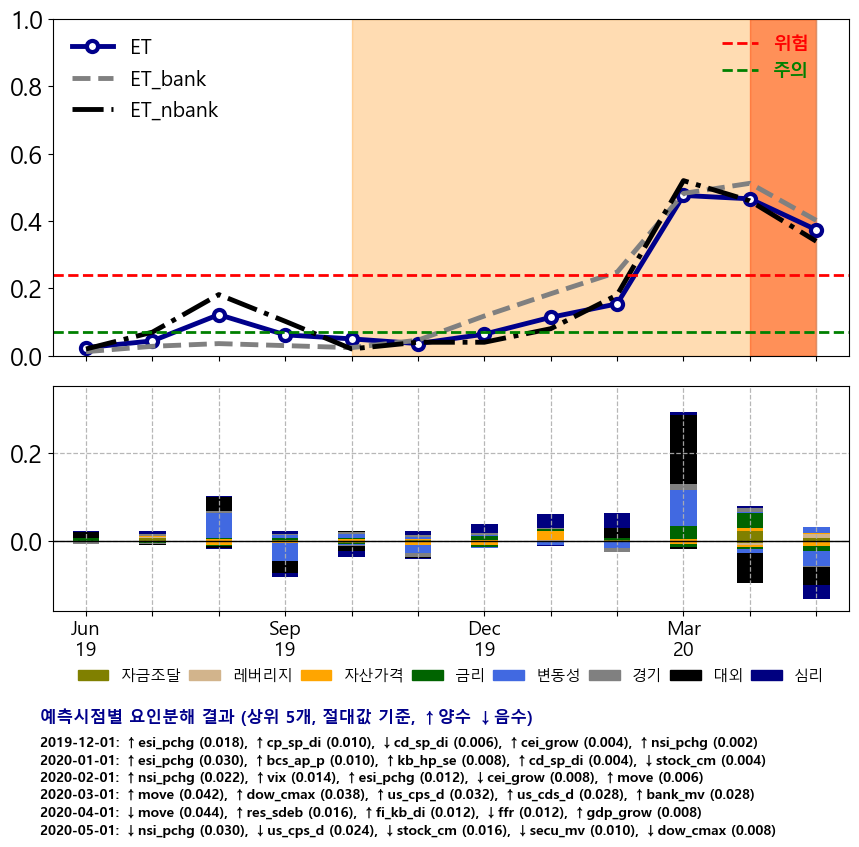

In [146]:
train_and_predict(train_from, train_to, predict_from, predict_to,
                  fig_name='figure/ews_simulation3_sector', print_text=True, model_type='sector')

### 레고랜드 (2021.9 ~ 2023.1)

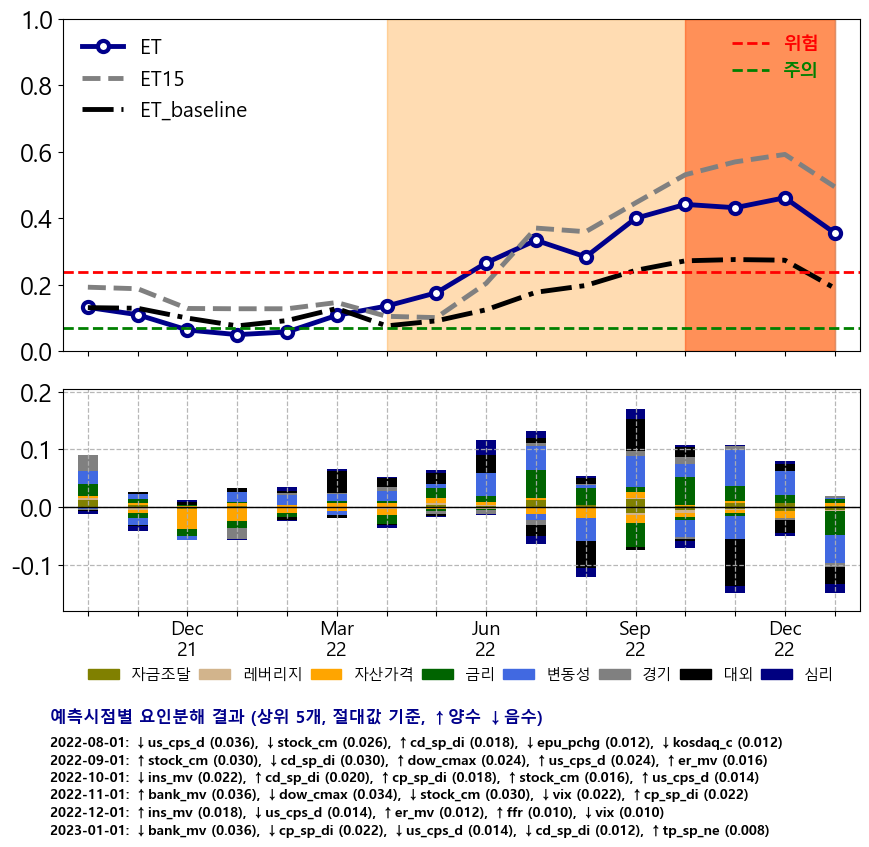

In [147]:
train_from = '1999-01'
train_to = '2021-08'
predict_from = '2021-09'
predict_to = '2023-01'

train_and_predict(train_from, train_to, predict_from, predict_to,
                  fig_name='figure/ews_simulation4', print_text=True, model_type='comparison')

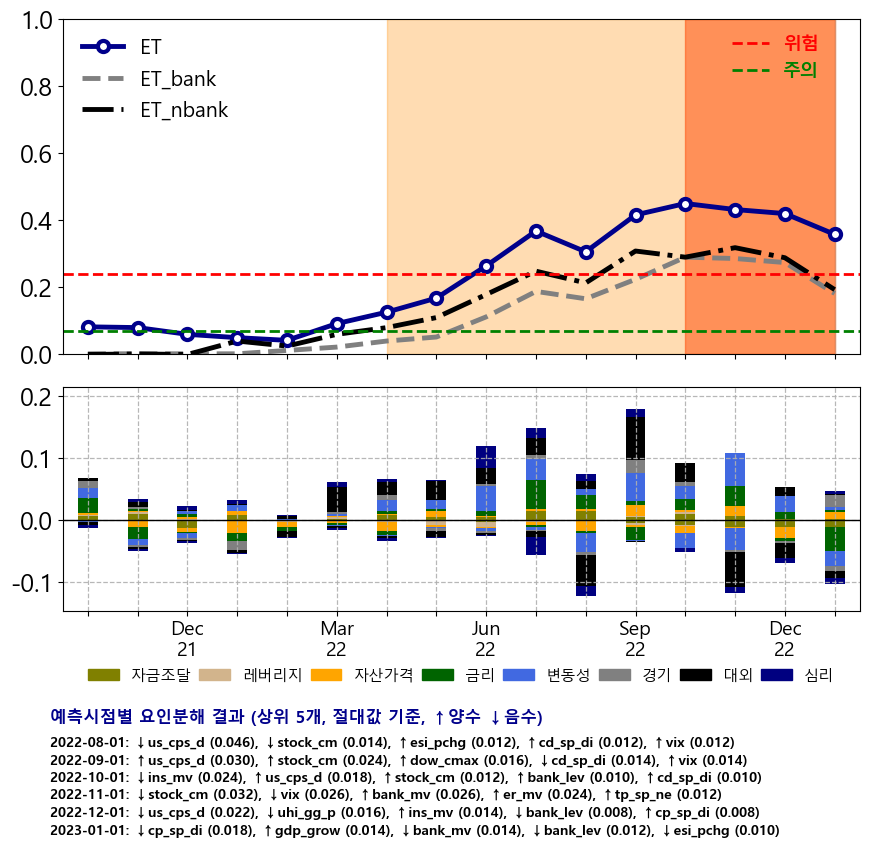

In [148]:
train_and_predict(train_from, train_to, predict_from, predict_to,
                  fig_name='figure/ews_simulation4_sector', print_text=True, model_type='sector')

# Ⅲ. 모형 학습 및 예측

## 1 학습

In [149]:
from sklearn.ensemble import ExtraTreesClassifier

# 모델 초기화
# model_param = {'max_depth': 40, 'max_features': 10, 'n_estimators': 1000}
# model_param_bank = {'max_depth': 30, 'max_features': 7, 'n_estimators': 1000}
# model_param_nbank = {'max_depth': 10, 'max_features': 10, 'n_estimators': 1000}
# model_param_old = {'max_depth': 15, 'max_features': 3, 'n_estimators': 1000}
model_param = best_params_et
model_param_bank = best_params_bank_et
model_param_nbank = best_params_nbank_et
model_param_old = best_params_old_et
model_param_og = best_params_og_et

model = ExtraTreesClassifier()
model_bank = ExtraTreesClassifier()
model_nbank = ExtraTreesClassifier()
model_old = ExtraTreesClassifier()
model_og = ExtraTreesClassifier()

model.set_params(**model_param)
model_bank.set_params(**model_param_bank)
model_nbank.set_params(**model_param_nbank)
model_old.set_params(**model_param_old)
model_og.set_params(**model_param_og)

et = ews.EarlyWarningModel(model)
et_bank = ews.EarlyWarningModel(model_bank)
et_nbank = ews.EarlyWarningModel(model_nbank)
et_old = ews.EarlyWarningModel(model_old)
et_og = ews.EarlyWarningModel(model_og)

# 학습 및 결과 저장
train_from = '1999-01'
train_to = '2023-12'
model_id = '20250630'

train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
X_train = table[features['id']][train_idx]
y_train = crises.ext_term[train_idx]

et.train(X_train, y_train)
et.save(model_id)

model_id = '20250630_bank'

train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises_bank.post_term == 0)
X_train = table[features['id']][train_idx]
y_train = crises_bank.ext_term[train_idx]

et_bank.train(X_train, y_train)
et_bank.save(model_id)

model_id = '20250630_nbank'

train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises_nbank.post_term == 0)
X_train = table[features['id']][train_idx]
y_train = crises_nbank.ext_term[train_idx]

et_nbank.train(X_train, y_train)
et_nbank.save(model_id)

model_id = '20250630_15var'

train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
X_train = table[features_old['id']][train_idx]
y_train = crises.ext_term[train_idx]

et_old.train(X_train, y_train)
et_old.save(model_id)

model_id = '20250630_baseline'

train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises_og.post_term == 0)
X_train = table[features_old['id']][train_idx]
y_train = crises_og.ext_term[train_idx]

et_og.train(X_train, y_train)
et_og.save(model_id)


In [150]:
# pdp two-way
#ews.plot_pdp_twoway(et.model, et.scale(X_train), features['name'], features['type'])

## 2 전망

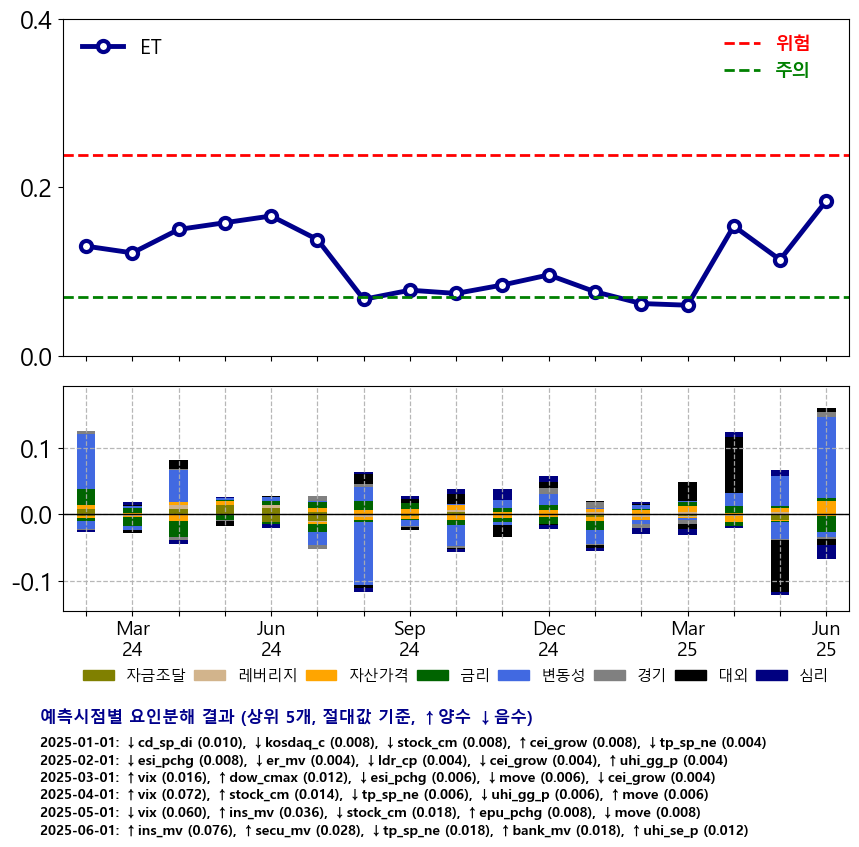

In [153]:
# 모델 로드 및 전망
model_id = '20250630'
predict_from = '2024-1'
predict_to = '2025-12'

et = ews.EarlyWarningModel()
et.load(model_id)

predict_idx = (predict_from <= table.index) & (table.index <= predict_to) # table.index를 기준으로 예측구간 설정
X = table[features['id']][predict_idx]

et_results, et_impacts = et.predict(X, True)
result = {'ET': et_results}

#thr_w, thr_r = ews.map_fsi_thr_to_prob(cfpi_fsi['fsi'], 12, 24, preds['ET'])
ews.plot_pred_decomp(result, et_impacts, features['id'], features['group'], 
                     perc70=perc70, perc90=perc85, ax1_ylim=[0, 0.4], fig_name='figure/ews_et_recent', print_text=True)

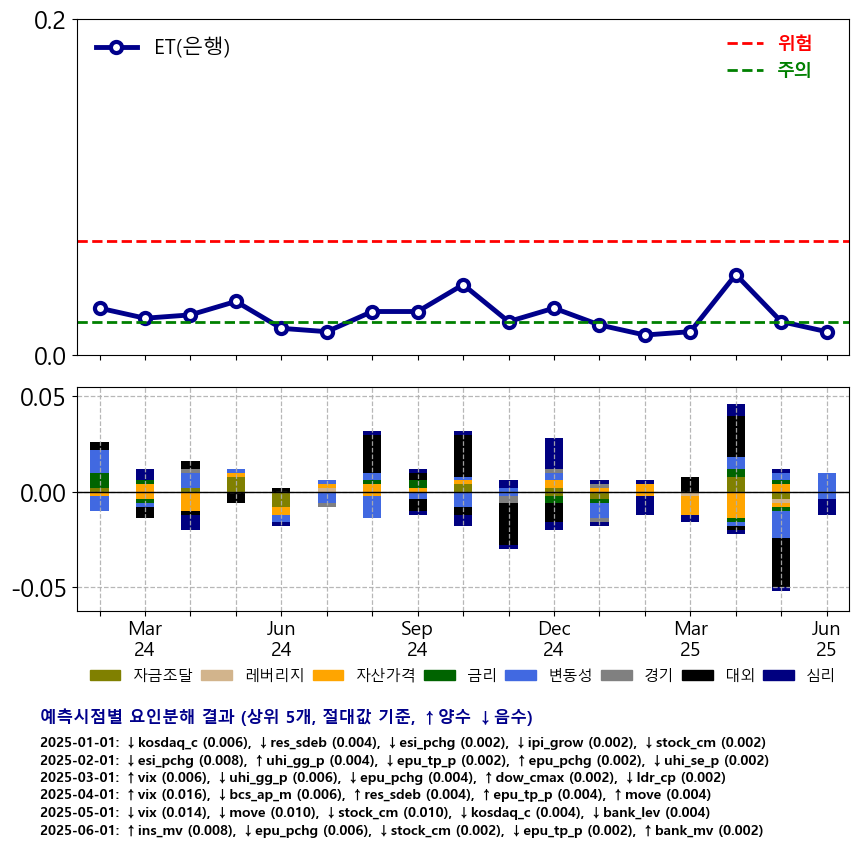

In [156]:
# 모델 로드 및 전망
model_id = '20250630_bank' # 위기식별 방식과 변수의 수를 새로운 기준으로 고정한 상태에서 은행부문(구cfpi)만으로 학습한 모형

et = ews.EarlyWarningModel()
et.load(model_id)

et_results, et_impacts = et.predict(X, True)
result = {'ET(은행)': et_results}

#thr_w, thr_r = ews.map_fsi_thr_to_prob(cfpi_fsi['fsi'], 12, 24, preds_bank['ET'])
ews.plot_pred_decomp(result, et_impacts, features['id'], features['group'], 
                     perc70=perc70_bank, perc90=perc85_bank, ax1_ylim=[0, 0.2], fig_name='figure/ews_et_bank_recent', print_text=True)

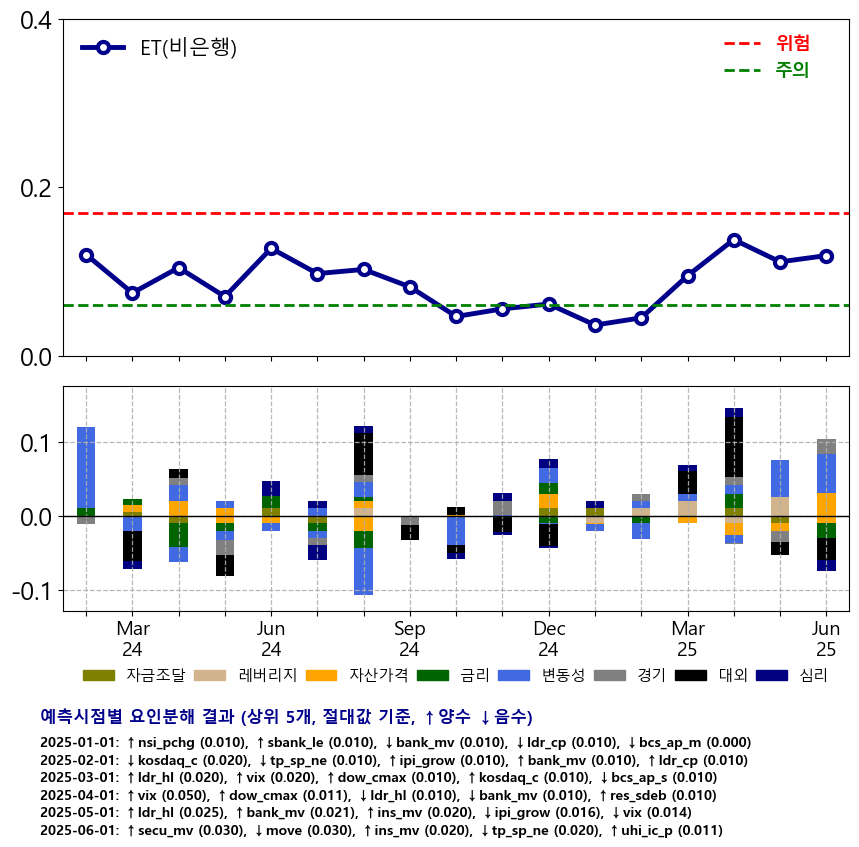

In [159]:
# 모델 로드 및 전망
model_id = '20250630_nbank' # 비은행

et = ews.EarlyWarningModel()
et.load(model_id)

et_results, et_impacts = et.predict(X, True)
result = {'ET(비은행)': et_results}

#thr_w, thr_r = ews.map_fsi_thr_to_prob(cfpi_fsi['fsi'], 12, 24, preds_bank['ET'])
ews.plot_pred_decomp(result, et_impacts, features['id'], features['group'], 
                     perc70=perc70_nbank, perc90=perc85_nbank, ax1_ylim=[0, 0.4], fig_name='figure/ews_et_nbank_recent', print_text=True)

In [191]:
ipl.reload(ews)

<module 'ews' from 'c:\\Users\\BOK\\Desktop\\pyprojects\\ews\\ews.py'>

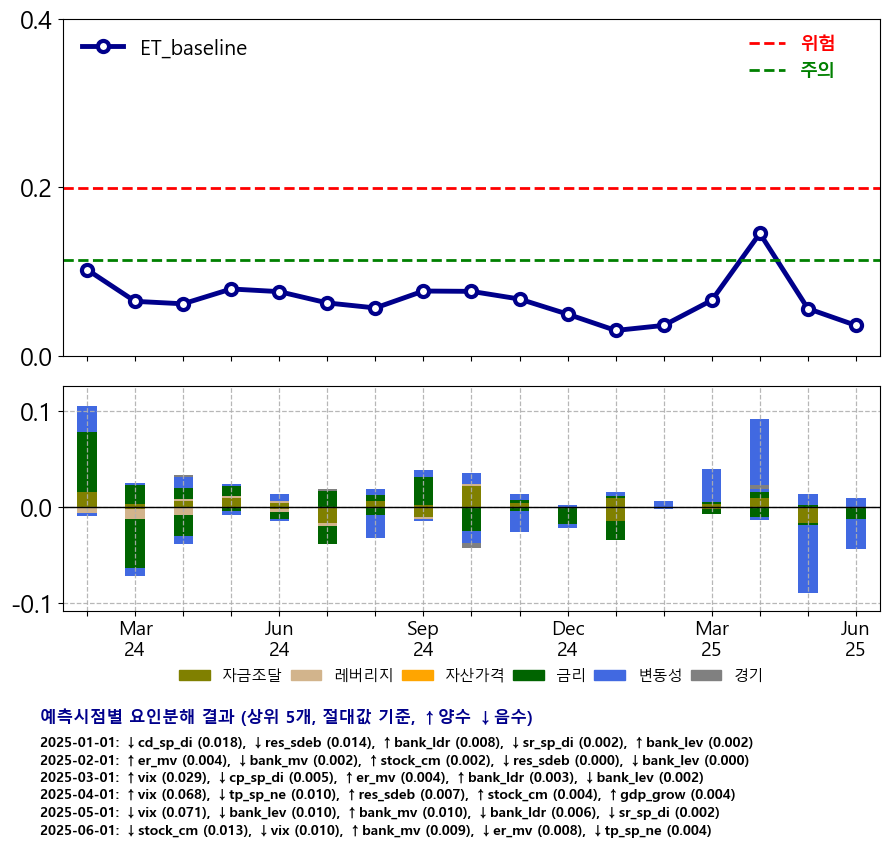

In [192]:
# 모델 로드 및 전망
model_id = '20250630_baseline' # 위기식별 방식과 비은행 추가한 부문을 고정한 상태에서 변수의 수만 과거 모형의 숫자로 학습한 모형

et = ews.EarlyWarningModel()
et.load(model_id)

X = table[features_old['id']][predict_idx]
et_results, et_impacts = et.predict(X, True)
result = {'ET_baseline': et_results}

#thr_w, thr_r = ews.map_fsi_thr_to_prob(cfpi_fsi['fsi'], 12, 24, preds_old['ET'])
# 기본 팔레트값
palette = {'자금조달': 'olive', '레버리지': 'tan', '자산가격': 'orange', '금리': 'darkgreen', '변동성': 'royalblue', '경기': 'grey'}

ews.plot_pred_decomp(result, et_impacts, features_old['id'], features_old['group'], 
                     perc70=perc70_og, perc90=perc85_og, ax1_ylim=[0, 0.4], palette=palette, legend_col=6,
                     fig_name='figure/ews_et_baseline_recent', print_text=True)

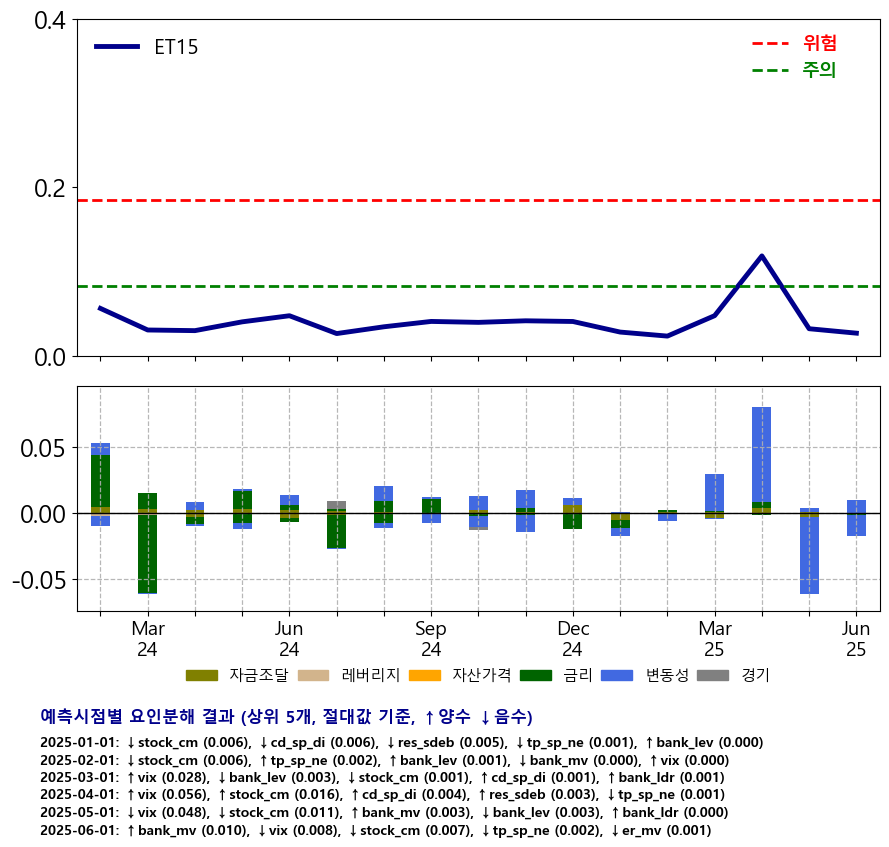

In [186]:
# 모델 로드 및 전망
model_id = '20250630_15var' # 위기식별 방식과 비은행 추가한 부문을 고정한 상태에서 변수의 수만 과거 모형의 숫자로 학습한 모형

et = ews.EarlyWarningModel()
et.load(model_id)

X = table[features_old['id']][predict_idx]
et_results, et_impacts = et.predict(X, True)
result = {'ET15': et_results}

#thr_w, thr_r = ews.map_fsi_thr_to_prob(cfpi_fsi['fsi'], 12, 24, preds_old['ET'])
# 기본 팔레트값
palette = {'자금조달': 'olive', '레버리지': 'tan', '자산가격': 'orange', '금리': 'darkgreen', '변동성': 'royalblue', '경기': 'grey'}

ews.plot_pred_decomp(result, et_impacts, features_old['id'], features_old['group'], 
                     perc70=perc70_old, perc90=perc80_old, ax1_ylim=[0, 0.4], palette=palette, legend_col=6,
                     fig_name='pred_decomp_et_15', print_text=True)

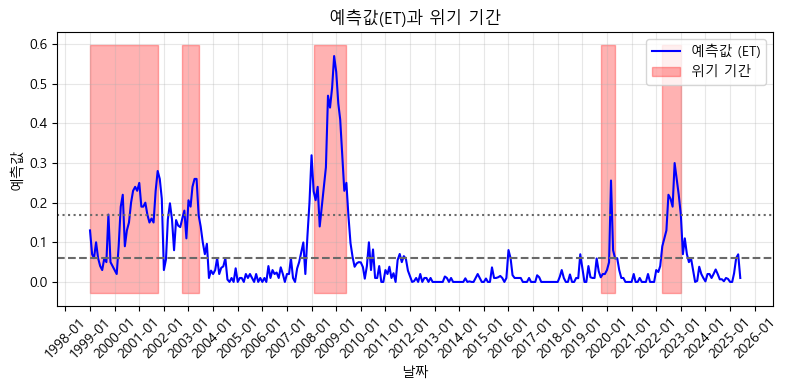

In [198]:
# preds['ET']와 crises.term을 플롯하기 (Period 인덱스 처리 포함)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 플롯 설정
fig, ax = plt.subplots(figsize=(8, 4))

# Period 인덱스를 datetime으로 변환
if hasattr(preds_nbank['ET'].index, 'to_timestamp'):
    # Period 인덱스인 경우
    x_axis = preds_nbank['ET'].sort_index().index.to_timestamp()
else:
    # 이미 datetime 인덱스인 경우
    x_axis = preds_nbank['ET'].sort_index().index

# preds['ET'] 시계열 플롯
ax.plot(x_axis, preds_nbank['ET'].sort_index(), 
        label='예측값 (ET)', color='blue', linewidth=1.5)

# crises.term 위기 기간 음영 처리
ymin, ymax = ax.get_ylim()
ax.fill_between(x_axis, ymin, ymax, 
                where=crises.ext_term,
                alpha=0.3, color='red',
                label='위기 기간')

# 그래프 설정
ax.set_xlabel('날짜')
ax.set_ylabel('예측값')
ax.set_title('예측값(ET)과 위기 기간')
ax.legend()
ax.grid(True, alpha=0.3)
 
perc70 = preds_nbank['ET'].sort_index().quantile(0.70)
perc80 = preds_nbank['ET'].sort_index().quantile(0.80)
perc85 = preds_nbank['ET'].sort_index().quantile(0.85)
perc90 = preds_nbank['ET'].sort_index().quantile(0.90)
# 70분위, 90분위 기준선 표시
ax.axhline(perc70, color='dimgrey', linestyle='--', lw=1.5)
ax.axhline(perc85, color='dimgrey', linestyle=':', lw=1.5)

# 날짜 축 포맷
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 빈티지 데이터를 이용한 주간 조기경보지수 산출 (2025년 3월-6월)

In [160]:
ipl.reload(ews)

<module 'ews' from 'c:\\Users\\BOK\\Desktop\\pyprojects\\ews\\ews.py'>

In [ ]:
# 빈티지 폴더 및 파일 설정
vintage_folder = 'vintages'
fd = '2025-06-23'

# 빈티지 날짜 범위 계산
start_date, end_date = ews.get_vintage_date_range(fd, months_back=3)  # 3개월 전부터
print(f"빈티지 기간: {start_date} ~ {end_date}")

# 빈티지 파일 목록 가져오기
vintage_files = ews.get_vintage_files(vintage_folder, start_date, end_date)
print(f"빈티지 파일 수: {len(vintage_files)}")
print(f"빈티지 파일 목록: {vintage_files[:5]}...{vintage_files[-3:] if len(vintage_files) > 5 else []}")

# 빈티지별 마지막 시점 값으로 구성된 X 생성
X_vintage_combined = ews.gen_vintage_combinded(vintage_folder, vintage_files, features)

빈티지 기간: 2025-03-03 ~ 2025-06-23
빈티지 파일 수: 17
빈티지 파일 목록: ['2025-03-03.csv', '2025-03-10.csv', '2025-03-17.csv', '2025-03-24.csv', '2025-03-31.csv']...['2025-06-09.csv', '2025-06-16.csv', '2025-06-23.csv']

=== X_vintage_combined ===
크기: (17, 43)
인덱스 타입: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
인덱스 범위: 2025-03-03 00:00:00 ~ 2025-06-23 00:00:00
feature 수: 43


In [170]:
# X_vintage_combined의 복사본을 만들고, 인덱스를 빈티지 시점으로 유지
X_vintage_weekly = X_vintage_combined.copy()

print(f"X_vintage_weekly 크기: {X_vintage_weekly.shape}")
print(f"인덱스 타입: {type(X_vintage_weekly.index[0])}")
print(f"인덱스 범위: {X_vintage_weekly.index[0]} ~ {X_vintage_weekly.index[-1]}")

X_vintage_weekly 크기: (17, 43)
인덱스 타입: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
인덱스 범위: 2025-03-03 00:00:00 ~ 2025-06-23 00:00:00



빈티지 시점별 예측 및 기여도 분해 실행 중...
=== 빈티지 시점별 ews.plot_pred_decomp 차트 생성 ===
Results: ['ET']
Results shape: (17, 1)
Impacts shape: (688, 1)
Feature 수: 43
빈티지 시점 수: 17
기여도 시점 수: 16


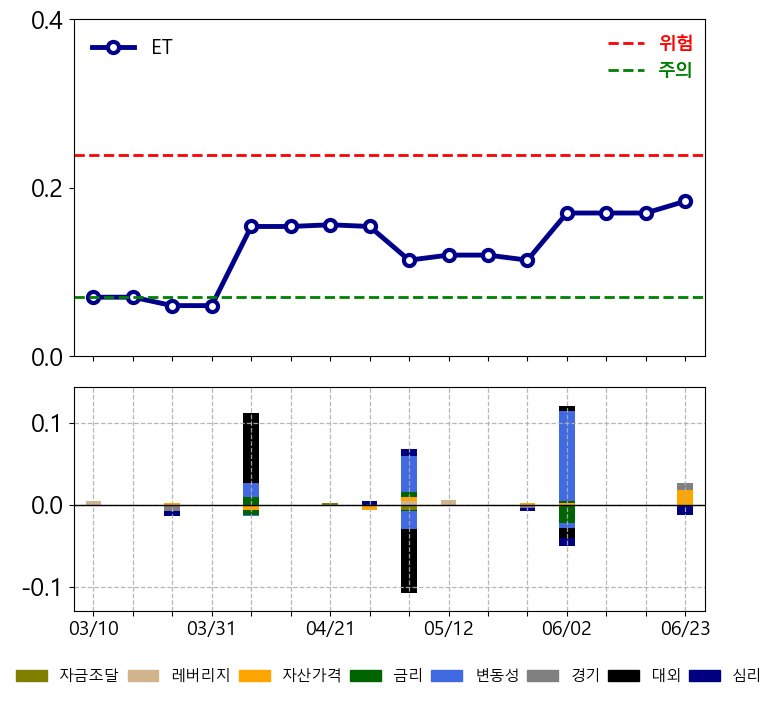

In [171]:
# 빈티지 시점별 예측 및 기여도 분해
print("\n빈티지 시점별 예측 및 기여도 분해 실행 중...")

model_id = '20250630'
et_vintage = ews.EarlyWarningModel()
et_vintage.load(model_id)

weekly_results, weekly_impacts = et_vintage.predict_weekly(X_vintage_weekly, decompose=True)

# 빈티지 시점별 예측 및 기여도 결과로 ews.plot_pred_decomp 차트 생성
print("=== 빈티지 시점별 ews.plot_pred_decomp 차트 생성 ===")

# results 형식으로 변환
weekly_results_dict = {'ET': weekly_results}
weekly_impacts_formatted = weekly_impacts.rename(columns={0: 'impact'})

feature_ids = features['id']
feature_groups = features['group']

print(f"Results: {list(weekly_results_dict.keys())}")
print(f"Results shape: {weekly_results.shape}")
print(f"Impacts shape: {weekly_impacts_formatted.shape}")
print(f"Feature 수: {len(feature_ids)}")
print(f"빈티지 시점 수: {len(weekly_results.index)}")
print(f"기여도 시점 수: {len(weekly_impacts_formatted.index.get_level_values(0).unique())}")

# ews.plot_pred_decomp 함수 호출
ews.plot_pred_decomp(
    results=weekly_results_dict,
    impacts=weekly_impacts_formatted, 
    feature_ids=feature_ids,
    feature_groups=feature_groups,
    crises=None,
    perc70=perc70,
    perc90=perc85,
    ax1_ylim=[0, 0.4],
    figsize=(8, 7),  
    fig_name='vintage_weekly_pred_decomp',
    print_text=False,
    is_save_fig=False
)

빈티지 시점별 예측 및 기여도 분해 실행 중...


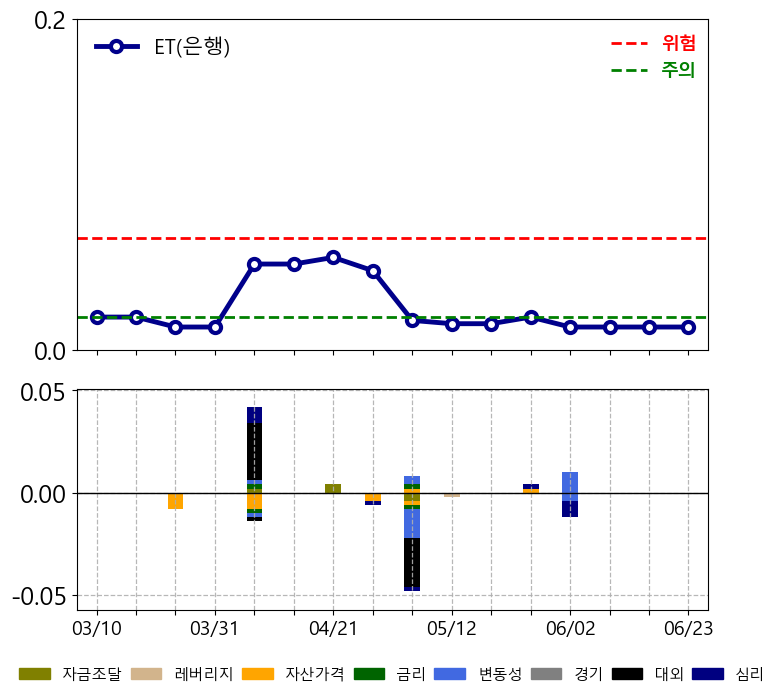

In [172]:
# 빈티지 시점별 예측 및 기여도 분해
print("빈티지 시점별 예측 및 기여도 분해 실행 중...")

model_id = '20250630_bank'
et_vintage = ews.EarlyWarningModel()
et_vintage.load(model_id)

weekly_results_bank, weekly_impacts_bank = et_vintage.predict_weekly(X_vintage_weekly, decompose=True)

# results 형식으로 변환
weekly_results_dict = {'ET(은행)': weekly_results_bank}
weekly_impacts_formatted_bank = weekly_impacts_bank.rename(columns={0: 'impact'})

feature_ids = features['id']
feature_groups = features['group']

# ews.plot_pred_decomp 함수 호출
ews.plot_pred_decomp(
    results=weekly_results_dict,
    impacts=weekly_impacts_formatted_bank, 
    feature_ids=feature_ids,
    feature_groups=feature_groups,
    crises=None,
    perc70=perc70_bank,
    perc90=perc85_bank,
    ax1_ylim=[0, 0.2],
    figsize=(8, 7),  
    fig_name='vintage_weekly_pred_decomp',
    print_text=False,
    is_save_fig=False
)

빈티지 시점별 예측 및 기여도 분해 실행 중...


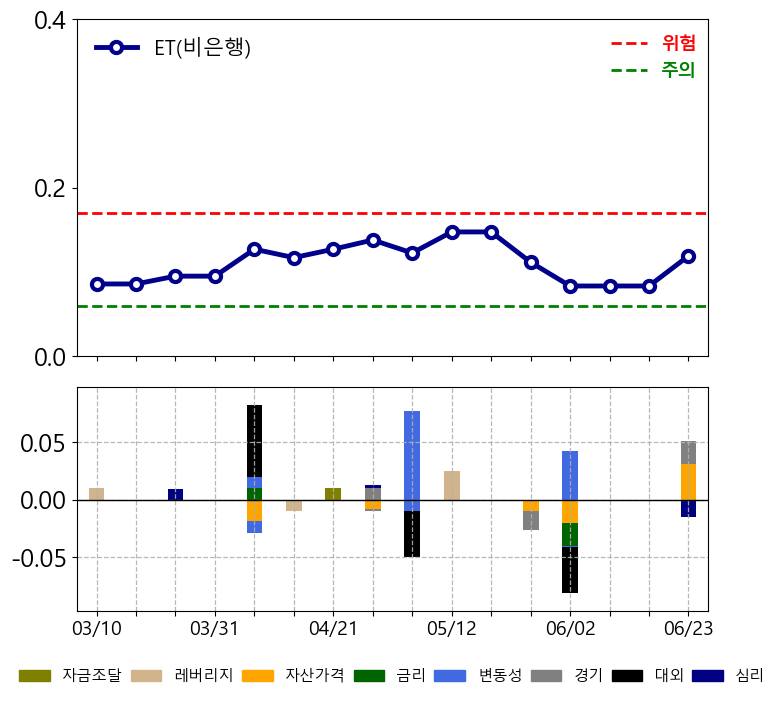

In [173]:
# 빈티지 시점별 예측 및 기여도 분해
print("빈티지 시점별 예측 및 기여도 분해 실행 중...")

model_id = '20250630_nbank'
et_vintage = ews.EarlyWarningModel()
et_vintage.load(model_id)

weekly_results_nbank, weekly_impacts_nbank = et_vintage.predict_weekly(X_vintage_weekly, decompose=True)

# results 형식으로 변환
weekly_results_dict = {'ET(비은행)': weekly_results_nbank}
weekly_impacts_formatted_nbank = weekly_impacts_nbank.rename(columns={0: 'impact'})

feature_ids = features['id']
feature_groups = features['group']

# ews.plot_pred_decomp 함수 호출
ews.plot_pred_decomp(
    results=weekly_results_dict,
    impacts=weekly_impacts_formatted_nbank, 
    feature_ids=feature_ids,
    feature_groups=feature_groups,
    crises=None,
    perc70=perc70_nbank,
    perc90=perc85_nbank,
    ax1_ylim=[0, 0.4],
    figsize=(8, 7),  
    fig_name='vintage_weekly_pred_decomp',
    print_text=False,
    is_save_fig=False
)

In [196]:
ipl.reload(ews)

<module 'ews' from 'c:\\Users\\BOK\\Desktop\\pyprojects\\ews\\ews.py'>

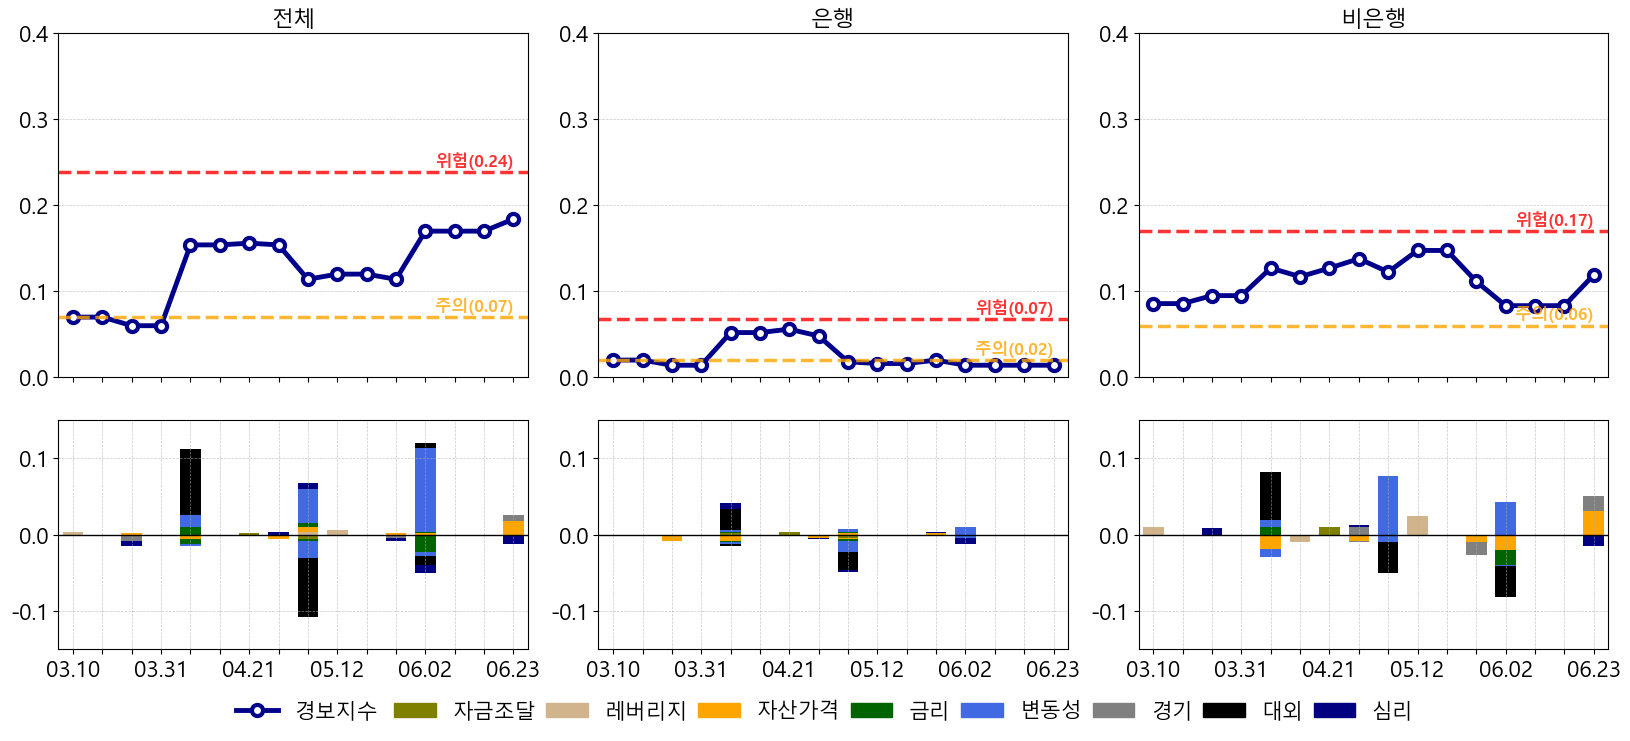

In [197]:
results_all = {'전체': {'ET': weekly_results},
               '은행': {'ET(은행)': weekly_results_bank},
               '비은행': {'ET(비은행)': weekly_results_nbank}}

impacts_all = {'전체': weekly_impacts_formatted,
               '은행': weekly_impacts_formatted_bank,
               '비은행': weekly_impacts_formatted_nbank}

perc70_dict = {'전체': perc70, '은행': perc70_bank, '비은행': perc70_nbank}
perc90_dict = {'전체': perc85, '은행': perc85_bank, '비은행': perc85_nbank}

ews.plot_pred_decomp_all(
    results_dict=results_all,
    impacts_dict=impacts_all, 
    feature_ids=feature_ids,
    feature_groups=feature_groups,
    perc70_dict=perc70_dict,
    perc90_dict=perc90_dict,
    figsize=(20, 8),
    fig_name='ews_all_sectors',
    is_save_fig=True
)